In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib as mpl

from pandas_datareader import data as pdr

import datetime as dt
import yfinance as yf

import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler
import os
from joblib import Parallel, delayed


# Set print options.

np.set_printoptions(precision = 3)

plt.style.use("ggplot") # Grammar of Graphics Theme

mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.color"] = "grey"
mpl.rcParams["grid.alpha"] = 0.25

mpl.rcParams["axes.facecolor"] = "white"

mpl.rcParams["legend.fontsize"] = 14

# plot inline
%matplotlib inline

from macd import MACD, DUAL_MACD,  compute_portfolio, run_macd_hyperparam_search, run_macd_hyperparam_search_with_regimes, generate_position
from momentum import SMA, evaluate_momentum_params, run_momentum_hyperparam_search
from performance_metrics import compute_performance_metrics
from supervised_learning import (
    SupervisedLearning,
    create_all_features,
    make_future_log_return,
    make_direction_label
)
from feature_engineering import create_all_features
from regime_clustering import compute_regime_clusters, assign_regimes

In [2]:
%reload_ext autoreload
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
from lets_plot import *
LetsPlot.setup_html()

#  <a id = "top"> Table of Contents </a> 

## [Part 1 - Trading Strategies](#part1)

> Building trading stragies with spy as tradeable Assets

## [Part 2 - Results of Strategies](#part2)

> Visualize results of strategies

## [Part 3 - Executive Summary](#part3)

> Reviewing strategies and backtest results

## [Part 4 - Self-Critique](#part4)

>  dissect and scrutinize our strategies through the lens of common biases and potential market shifts

## [Part 5 - Contribution Statement](#part5)

## <a id = "part1"></a><font color = blue> 👉 Part 1 - Trading strategies</font> [back to table of contents](#top) 

## Exploratory Data Analysis

In [4]:
# global variables

start_date = "2006-11-01"
end_date   = "2025-11-13"  # end is *exclusive*, so this covers up to 2025-11-12

In [5]:
spy =\
(
    yf.
    download(
        "^GSPC",
        start = start_date,
        end = end_date
    )
)

spy.columns =\
(
    spy
    .columns
    .droplevel(1) # level 0 --> Price; level 1 --> Ticker
)

spy

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000


In [6]:
df = spy.copy()

## Add Predictions

We transform future returns into predictive labels and train ML models to classify up/down movements, which later act as a filter for momentum trades.

In [7]:
Y_reg = make_future_log_return(spy, price_column="Close", horizon=1)
Y_clf = make_direction_label(Y_reg)   # 1 if up, 0 if down

In [8]:
X = create_all_features(
    spy,
    lagged_return_periods=[1,2,3,5,10],
    vol_periods=[20,60],
    sma_periods=[20,60],
    ema_periods=[10,30],
    rsi_periods=[10,30],
    stok_periods=[14],
    stod_periods=[3],
    roc_periods=[10],
    atr_periods=[5,14]
)


In [9]:
data = pd.concat([Y_clf, X], axis=1).dropna()

Y = data[Y_clf.name]
X = data[X.columns]

SL = SupervisedLearning()

X_train, X_test, Y_train, Y_test = SL.sequential_split(X, Y, train_frac=0.75)

Sequential Split: 3546 train / 1183 test samples


In [10]:
results = SL.run_all_classifiers(X_train, Y_train, X_test, Y_test)
results

Logistic: accuracy=0.5452
RandomForest: accuracy=0.4751
GradientBoosting: accuracy=0.4615
KNN_Classifier: accuracy=0.4827


,Model,Accuracy
0,Logistic,0.545224
1,RandomForest,0.475063
2,GradientBoosting,0.461538
3,KNN_Classifier,0.482671


In [11]:
result = SL.tune_probability_threshold(
    model = SL.get_classifier_by_name('Logistic'),
    X_train = X_train,
    y_train = Y_train,
    X_test  = X_test,
    y_test  = Y_test,
    thresholds = np.arange(0.50, 0.80, 0.01),
    return_metric="sharpe"
)

result["best_threshold"]
result["threshold_cv_results"].head()


Best Threshold = 0.500
threshold          0.500000
train_sharpe      16.070455
test_sharpe       15.881216
train_accuracy     0.555556
test_accuracy      0.545224
Name: 0, dtype: float64


,threshold,train_sharpe,test_sharpe,train_accuracy,test_accuracy
0,0.50,16.070455,15.881216,0.555556,0.545224
1,0.51,15.248894,15.275259,0.556402,0.542688
2,0.52,14.107627,14.541461,0.549069,0.535926
3,0.53,12.676720,13.789407,0.543711,0.524937
4,0.54,11.010402,12.589440,0.534969,0.508876


In [12]:
clf = result["model"]
best_th = result["best_threshold"]

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

# Probability SPY goes UP
p_train = clf.predict_proba(X_train_scaled)[:, 1]
p_test  = clf.predict_proba(X_test)[:, 1]
train_pred = (p_train > best_th).astype(int)
test_pred  = (p_test > best_th).astype(int)

In [13]:
df.loc[X_train.index, "ml_prob"] = p_train
df.loc[X_train.index, "ml_signal"] = train_pred

df.loc[X_test.index, "ml_prob"] = p_test
df.loc[X_test.index, "ml_signal"] = test_pred

df = df.bfill # just to complet the ml prob and ml signal accoridng

In [14]:
df.head(5)

AttributeError: 'function' object has no attribute 'head'

### Passive Returns

In [ ]:
split_idx = int(len(df) * 0.75)

df_train = df.iloc[:split_idx].copy()
df_test  = df.iloc[split_idx:].copy()

In [ ]:
def generate_passive_returns(df: pd.DataFrame):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df['Close']
            /
            df['Close'].shift(1)
            )
    )

    df['cumulative_passive_returns'] =\
    (
        np.exp(
            df['passive_returns']
            .fillna(0)
            .cumsum()
        )
    )
    return df

In [ ]:
df_train = generate_passive_returns(df_train)
df_test = generate_passive_returns(df_test)

In [ ]:
def plot_returns(df, y,
                date_column = 'Date',
                returns_column = 'cumulative_passive_returns'):
    
    melted = (
        df[[date_column, returns_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={returns_column: "blue"})
        + labs(
            title="Cumulative Returns",
            x="Date",
            y=y,
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [ ]:
plot_returns(
    df=df_train.reset_index(),
    y='Training Returns'
)

In [ ]:
plot_returns(
    df=df_test.reset_index(),
    y='Testing Returns'
)

In [ ]:
df_test

Price,Close,High,Low,Open,Volume,ml_prob,ml_signal,passive_returns,cumulative_passive_returns
Date,,,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,0.572003,1.0,NaN,1.000000
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,0.547191,1.0,-0.000345,0.999655
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.549588,1.0,0.001661,1.001317
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.526929,1.0,0.004700,1.006034
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,0.551681,1.0,-0.000569,1.005461
...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,0.609182,1.0,-0.011241,1.718211
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.577146,1.0,0.001261,1.720379
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.531692,1.0,0.015284,1.746875


<Axes: xlabel='Date'>

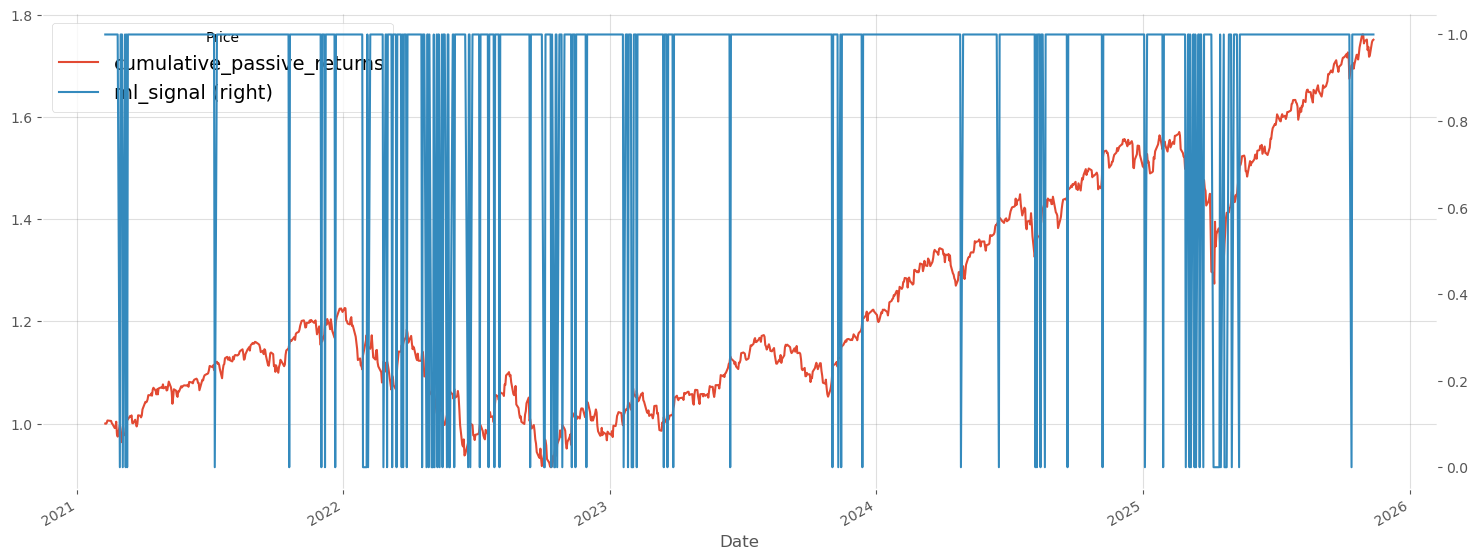

In [ ]:
(
    df_test[['cumulative_passive_returns','ml_signal']]
    .plot(secondary_y = "ml_signal",
          figsize = [18, 7]
         )
)

# Individual Strategies

In [ ]:
starting_capital = 100_000.0

In [ ]:
combined_results = []

In [ ]:
df_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns
Date,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,NaN,1.000000
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,-0.000345,0.999655
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.001661,1.001317
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.004700,1.006034
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,-0.000569,1.005461
...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875


## Buy and Hold

In [ ]:
buy_and_hold = \
(
    compute_performance_metrics(
        log_returns=df_test['passive_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Buy and Hold'
    )
)
print(buy_and_hold)

               CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Buy and Hold  0.125       0.171         0.254         0.776          1.273   

              Calmar Ratio  Final Portfolio Value  Cumulative Return  
Buy and Hold         0.492             175160.243              1.752  


In [ ]:
combined_results.append(buy_and_hold)

## 1.1 Mean Reversion A - Dynamic SMA, Std, BB + Regime ATR & Volatility Clustering

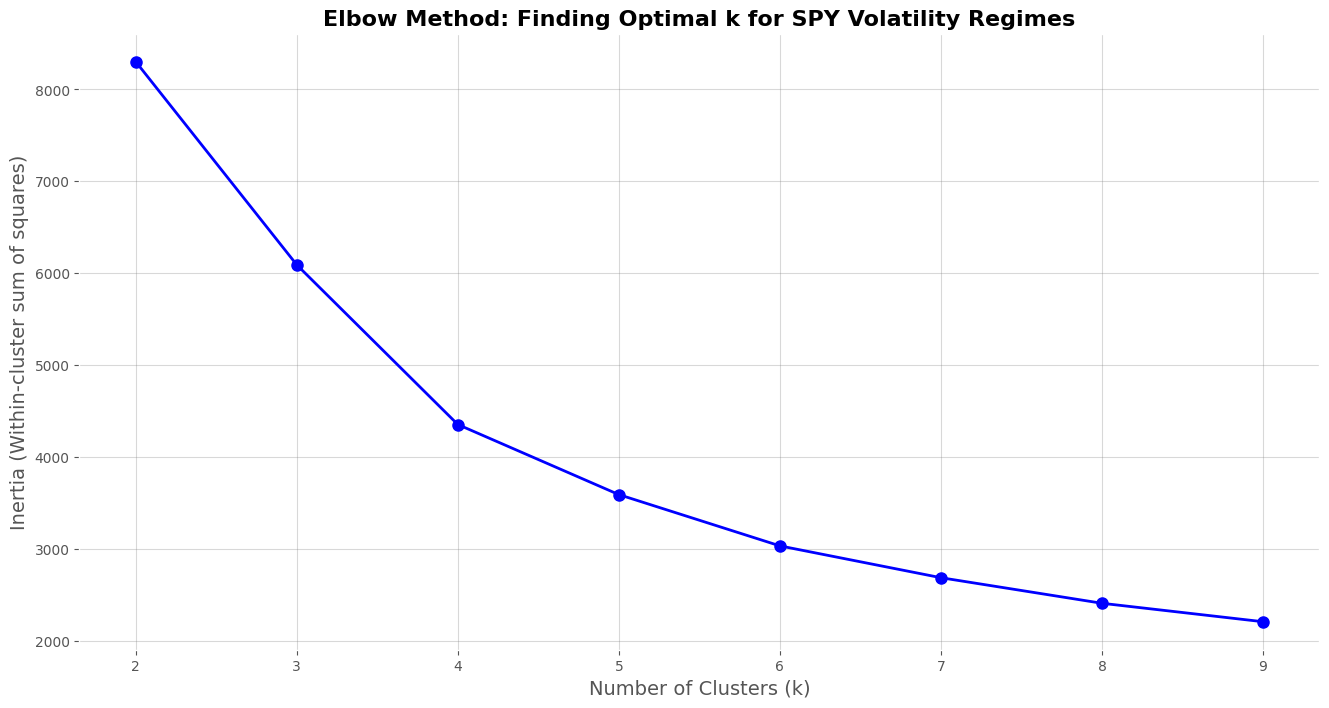

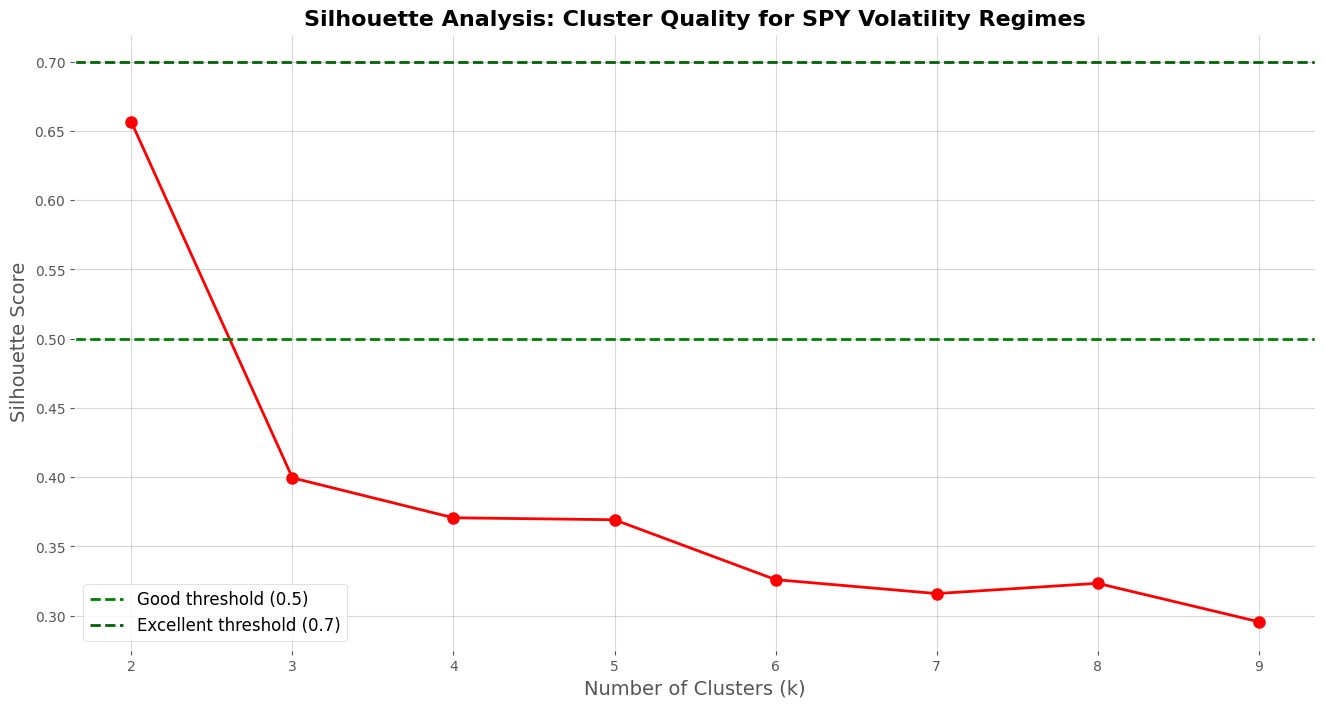

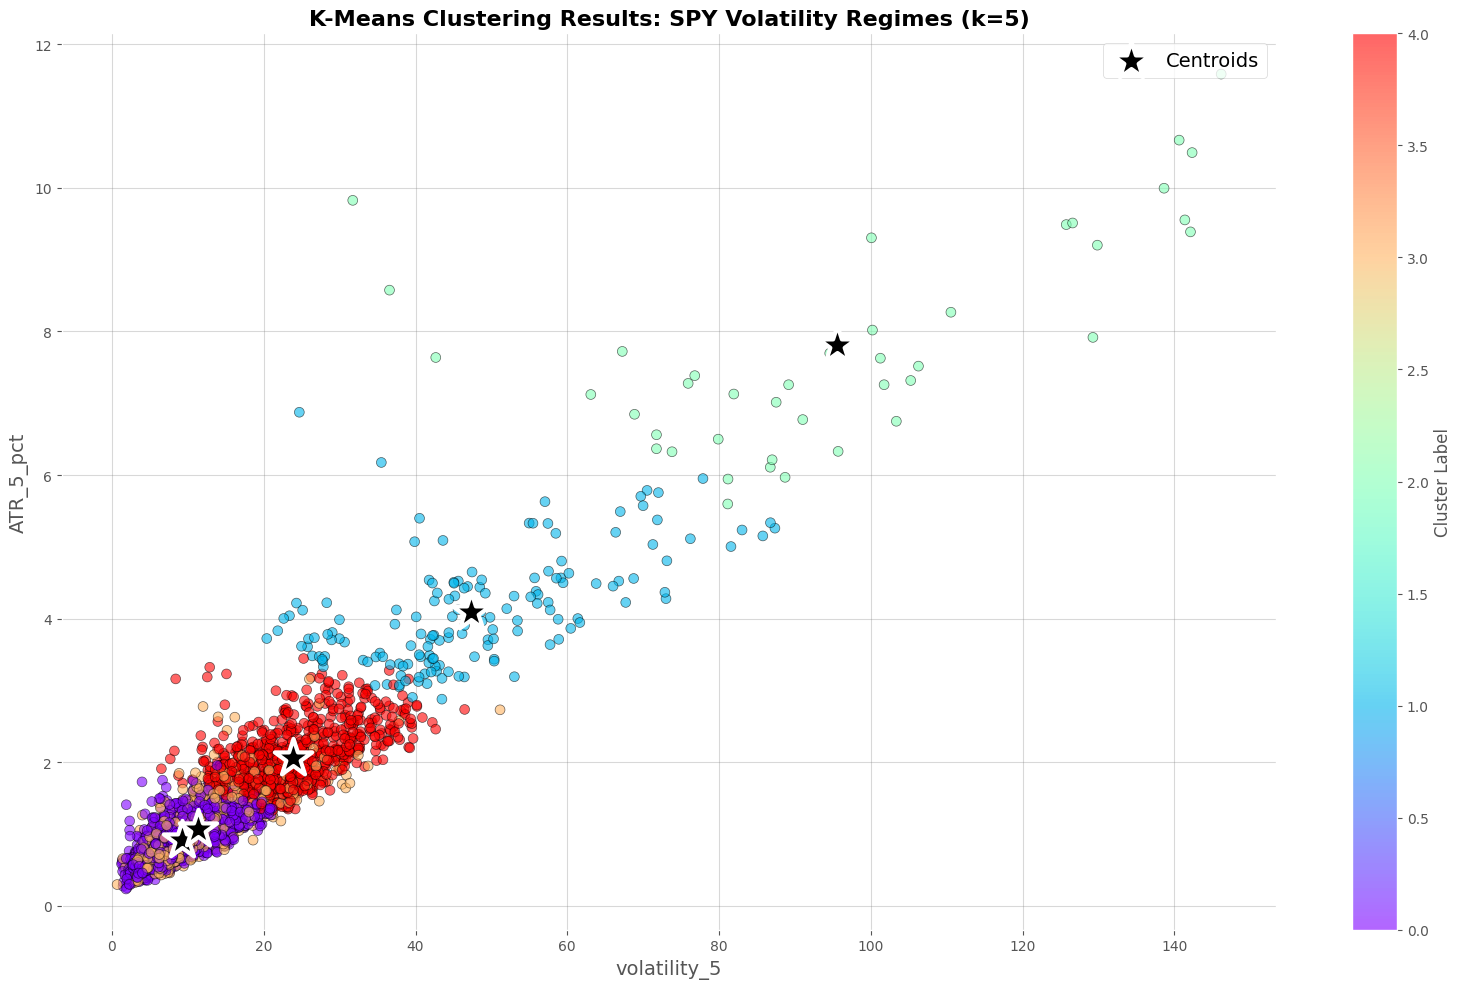

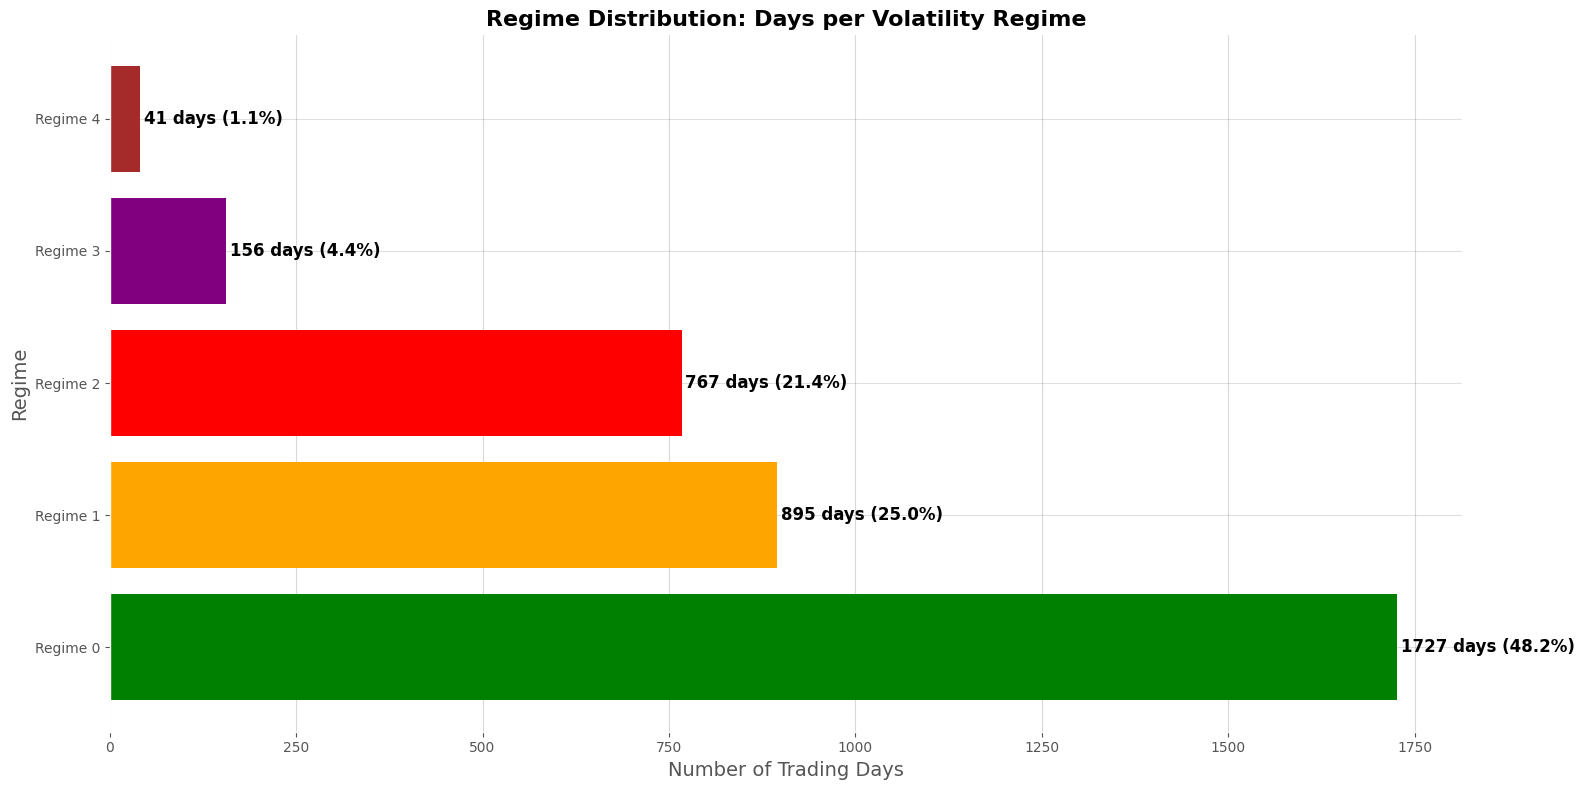


LOADING REGIME PARAMETERS FROM CSV FILES

GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...
✅ Loaded Very Low Vol (Calm): Window=5, Z_Long=-0.6, Z_Short=3.2
✅ Loaded Low Vol (Stable): Window=8, Z_Long=-0.8, Z_Short=2.2
✅ Loaded Medium Vol (Normal): Window=5, Z_Long=-1.1, Z_Short=1.7
✅ Loaded High Vol (Elevated): Window=7, Z_Long=-0.9, Z_Short=2.8
✅ Loaded Very High Vol (Crisis): Window=25, Z_Long=-0.8, Z_Short=2.5

✅ Loaded parameters for 5 regimes from CSV

UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA

Training Data Period:
  Start Date: 2006-11-01
  End Date:   2021-02-08
  Total Days: 3591

Testing strategy on FULL training data with regime transitions...

Regime Parameters Being Used:
  Very Low Vol (Calm): window=5, z_long=-0.6, z_short=3.2
  Low Vol (Stable): window=8, z_long=-0.8, z_short=2.2
  Medium Vol (Normal): window=5, z_long=-1.1, z_short=1.7
  High Vol (Elevated): window=7, z_long=-0.9, z_short=2.8
  Very High Vol (Crisis): window=25, z_long=-0.8, z_short=2

,Metric,Train,Test
0,Total Return (%),258.96,87.59
1,CAGR (%),9.37,14.14
2,Sharpe Ratio,0.67,1.23
3,Max Drawdown (%),-29.97,-11.60
4,Total Trades,310,115



GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY


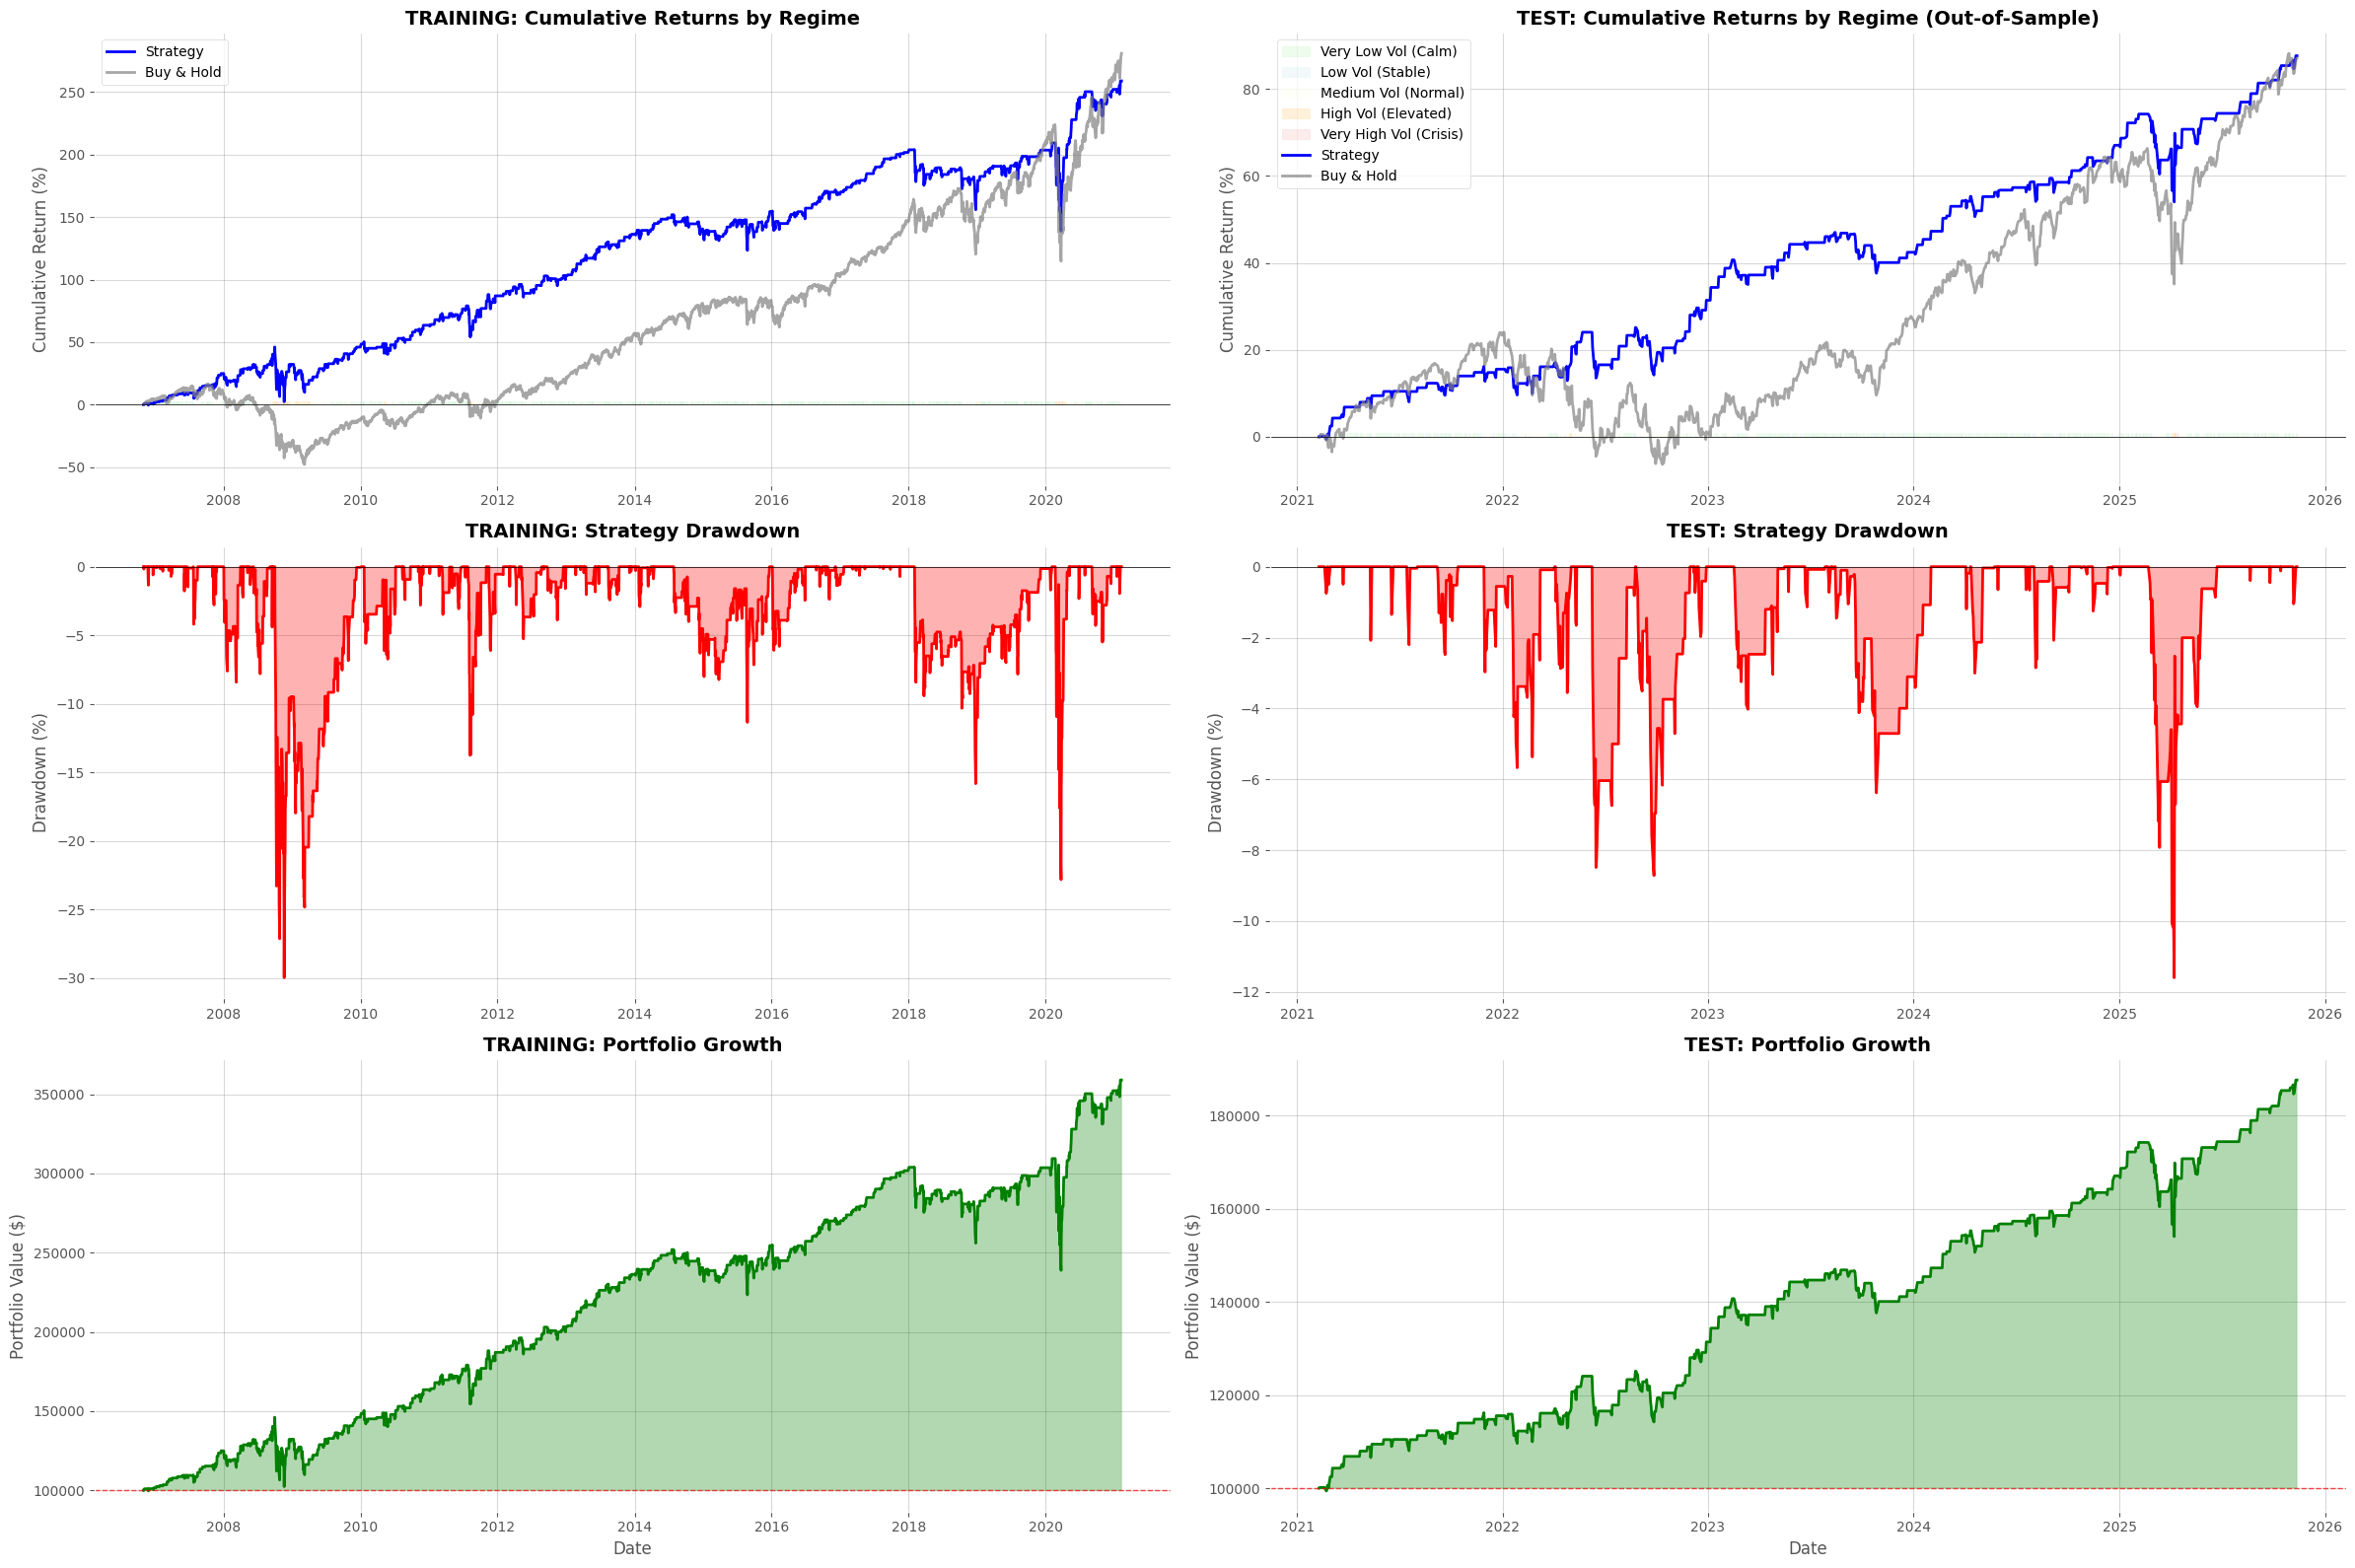


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                           258.96              87.59             280.95              87.04
Max Drawdown (%)                           -29.97             -11.60             -55.19             -24.50
Final Portfolio ($)            $       358,959.57 $       187,595.00 $       380,947.35 $       187,040.10


,Close,High,Low,Open,Volume,Adj_Close,returns_simple,returns_log,returns,volatility_3,volatility_5,volatility_10,volatility_20,volatility_30,volatility_60,...,dynamic_std,z_score,range_upper,range_lower,entry_long,exit_long,entry_short,exit_short,signal,shares,cash,portfolio_value,pnl,strategy_returns,signal_change
Date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2021-02-09,365.365509,365.964713,364.354388,364.766305,35551100,365.365509,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,0.000000,NaN,NaN,False,False,False,False,0,0,100000.000000,100000.000000,0.000000,0.000000,NaN
2021-02-10,365.206451,367.266179,362.790978,367.116378,59154400,365.206451,-0.000435,-0.000435,-0.000435,NaN,NaN,NaN,NaN,NaN,NaN,...,0.112471,-0.707107,365.645887,365.218498,True,False,False,False,1,268,2124.671021,100000.000000,0.000000,0.000000,1.0
2021-02-11,365.796234,366.713754,363.352675,366.292437,42913300,365.796234,0.001615,0.001614,0.001614,NaN,NaN,NaN,NaN,NaN,NaN,...,0.305141,1.114793,366.432517,365.272980,False,True,False,False,0,0,100158.061768,100158.061768,158.061768,0.001581,-1.0
2021-02-12,367.603271,367.846673,364.916253,364.991168,50593300,367.603271,0.004940,0.004928,0.004928,4.296272,NaN,NaN,NaN,NaN,NaN,...,1.102133,1.461171,369.519694,365.331586,False,False,False,False,0,0,100158.061768,100158.061768,0.000000,0.000000,0.0
2021-02-16,367.284851,369.035634,366.563961,368.839004,50972400,367.284851,-0.000866,-0.000867,-0.000867,4.615040,NaN,NaN,NaN,NaN,NaN,...,1.115737,0.926372,369.821621,365.581821,False,False,False,False,0,0,100158.061768,100158.061768,0.000000,0.000000,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,670.309998,677.380005,668.719971,676.469971,85035300,670.309998,-0.010729,-0.010787,-0.010787,13.608471,12.423531,13.151046,15.747516,13.171077,10.881087,...,5.871326,-1.710220,693.268174,675.654197,True,False,False,False,1,269,4287.638489,184601.027832,0.000000,-0.010483,0.0
2025-11-07,670.969971,671.080017,661.210022,667.909973,100592400,670.969971,0.000985,0.000984,0.000984,12.083887,11.806595,12.343911,11.986432,13.083059,10.880529,...,5.999375,-1.228467,691.538628,673.540504,False,False,False,False,1,269,4287.638489,184778.560608,0.000000,0.000962,0.0
2025-11-10,681.440002,682.179993,675.030029,677.239990,75842900,681.440002,0.015604,0.015484,0.015484,20.889559,17.919458,13.511068,12.026056,13.778296,11.273462,...,4.646683,1.362694,689.977382,672.319986,False,True,False,False,0,0,187594.999146,187594.999146,1667.803284,0.015242,-1.0


In [20]:
from mean_reversion_codebase import *
spy, spy_train, spy_test = mr_get_spy_raw()
spy_train_features, spy_test_features = mr_atr_volatility_kmeans_clustering(spy)
mean_reversion_A_test_unified_results = backtest_mean_reversion_sma_bb_strategy(spy_train_features, spy_test_features)
display(mean_reversion_A_test_unified_results)

## 1.2 Mean Reversion B - Dynamic RSI + Regime ATR & Volatility Clustering

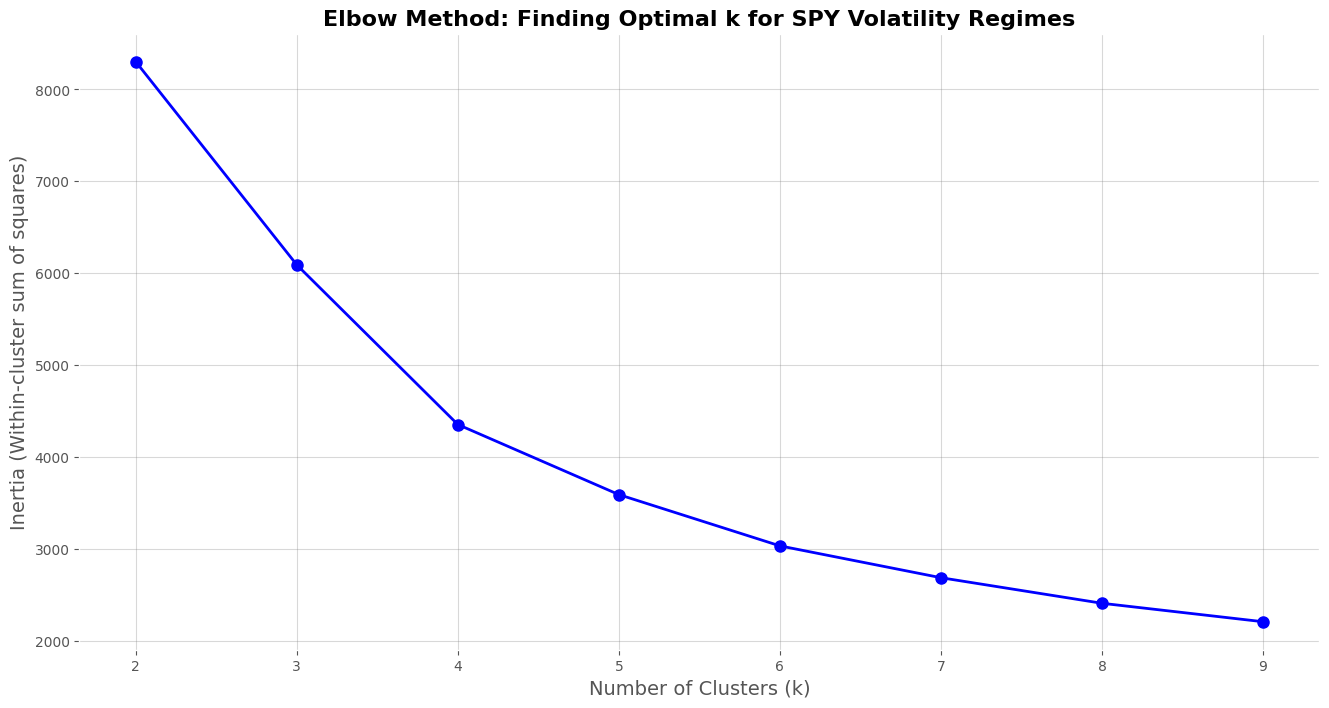

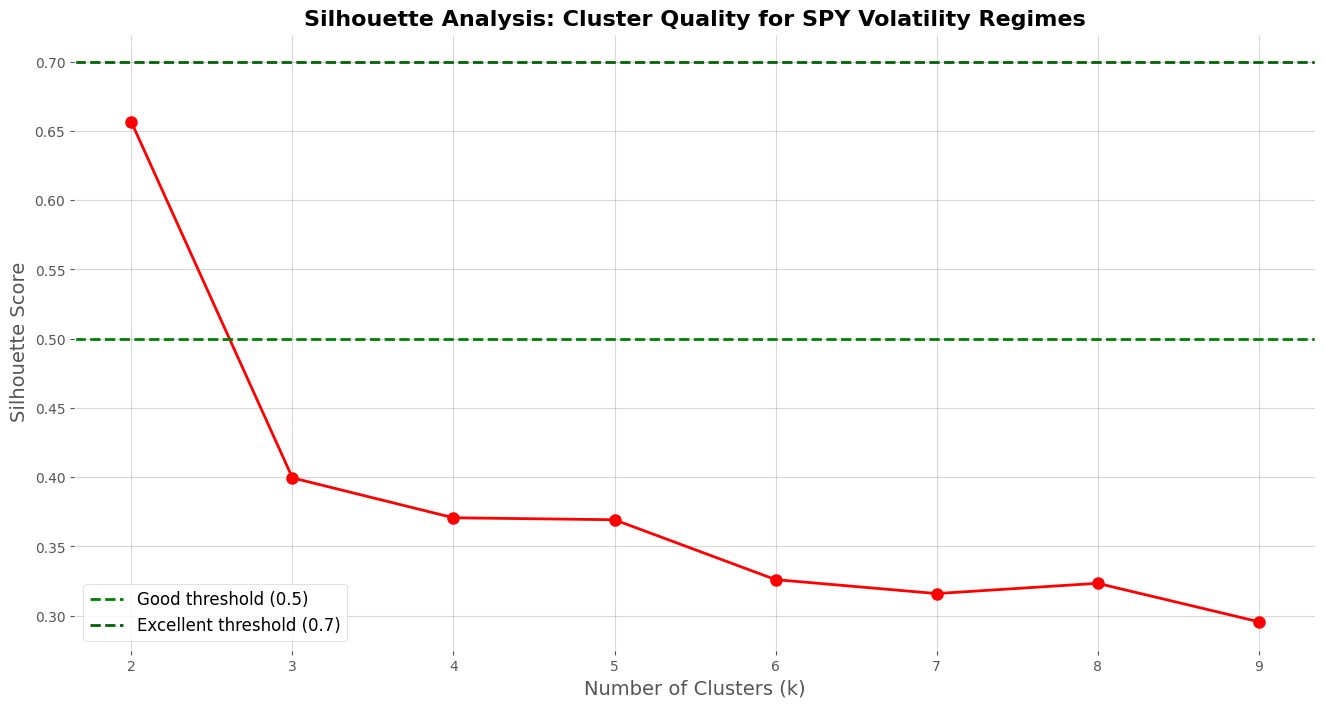

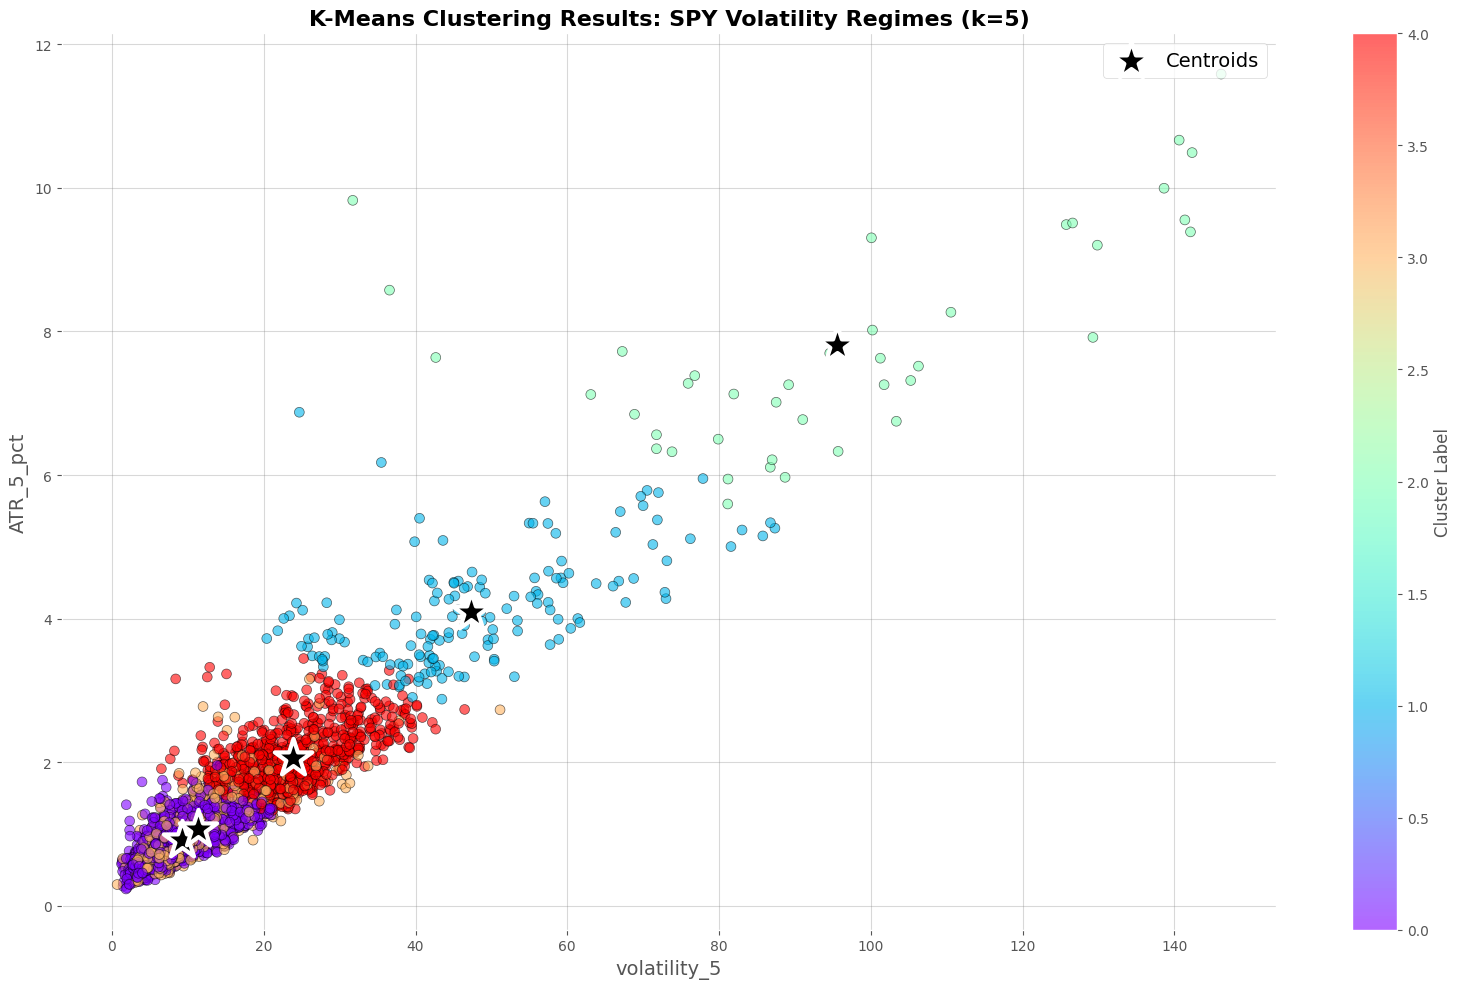

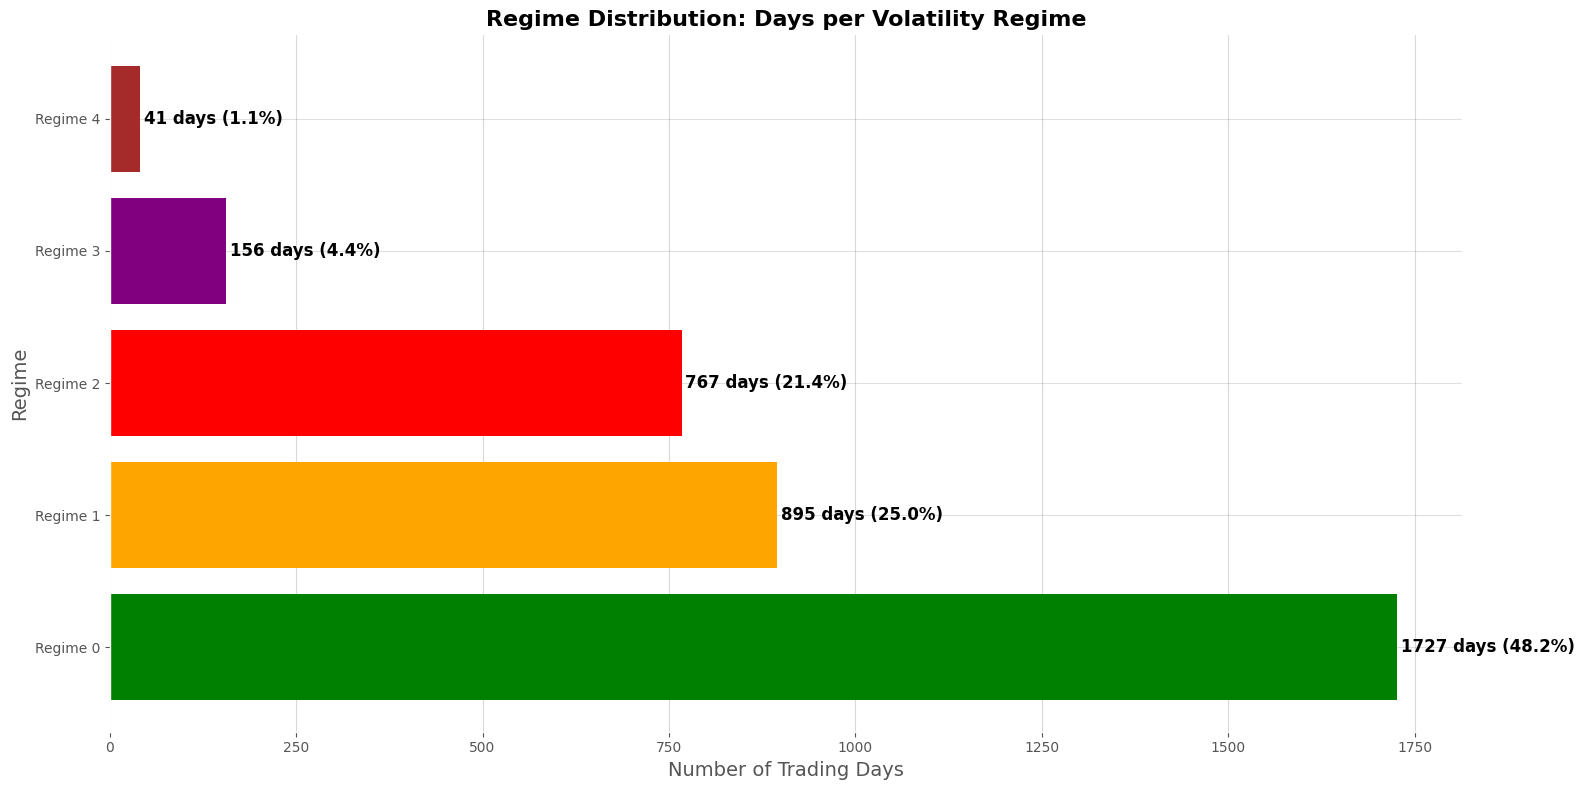


CALCULATING RSI FOR TRAIN AND TEST DATA
Train RSI - Mean: 55.55, Std: 11.51
Test RSI - Mean: 55.74, Std: 11.49


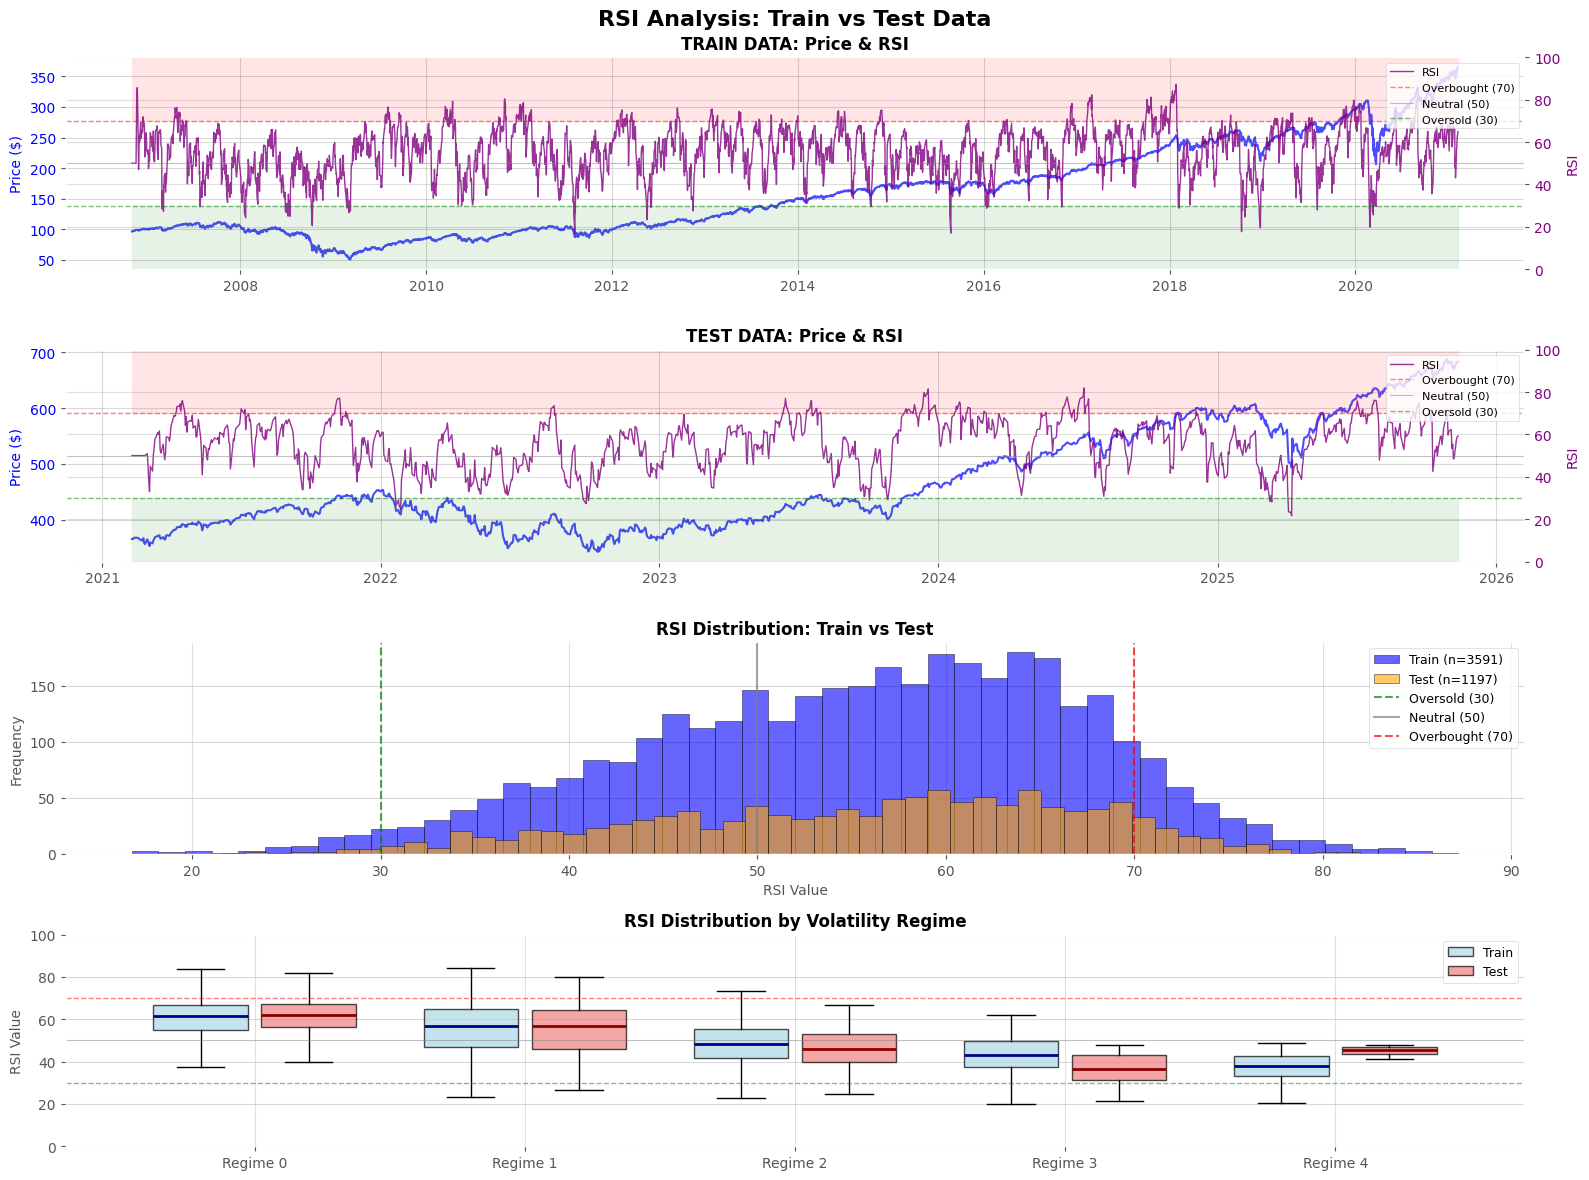


RSI STATISTICS

TRAIN DATA:
  Oversold (<30): 65 days (1.8%)
  Neutral (30-70): 3209 days (89.4%)
  Overbought (>70): 317 days (8.8%)

TEST DATA:
  Oversold (<30): 16 days (1.3%)
  Neutral (30-70): 1073 days (89.6%)
  Overbought (>70): 108 days (9.0%)

LOADING RSI REGIME PARAMETERS FROM CSV FILES
✅ Loaded Very Low Vol (Calm):
   RSI_Period=7, RSI_Oversold=35, RSI_Overbought=70
✅ Loaded Low Vol (Stable):
   RSI_Period=17, RSI_Oversold=33, RSI_Overbought=78
✅ Loaded Medium Vol (Normal):
   RSI_Period=10, RSI_Oversold=35, RSI_Overbought=68
✅ Loaded High Vol (Elevated):
   RSI_Period=13, RSI_Oversold=32, RSI_Overbought=68
✅ Loaded Very High Vol (Crisis):
   RSI_Period=33, RSI_Oversold=35, RSI_Overbought=85

✅ Loaded parameters for 5 regimes from CSV

UNIFIED REGIME-AWARE BACKTEST - TRAINING DATA

Training Data Period:
  Start Date: 2006-11-01
  End Date:   2021-02-08
  Total Days: 3591

Testing strategy on FULL training data with regime transitions...

Regime Parameters Being Used:
  Very

,Metric,Train,Test
0,Total Return (%),52.71,33.14
1,CAGR (%),3.01,6.20
2,Sharpe Ratio,0.30,0.62
3,Max Drawdown (%),-25.08,-10.70
4,Total Trades,126,47



💡 INTERPRETATION:
   - Similar Sharpe ratios → Good generalization, no overfitting
   - Test Sharpe much lower → May be overfitted to train data
   - Test Sharpe higher → Got lucky with test period or train was more volatile

GENERATING TRAIN vs TEST VISUALIZATION WITH REGIME OVERLAY...


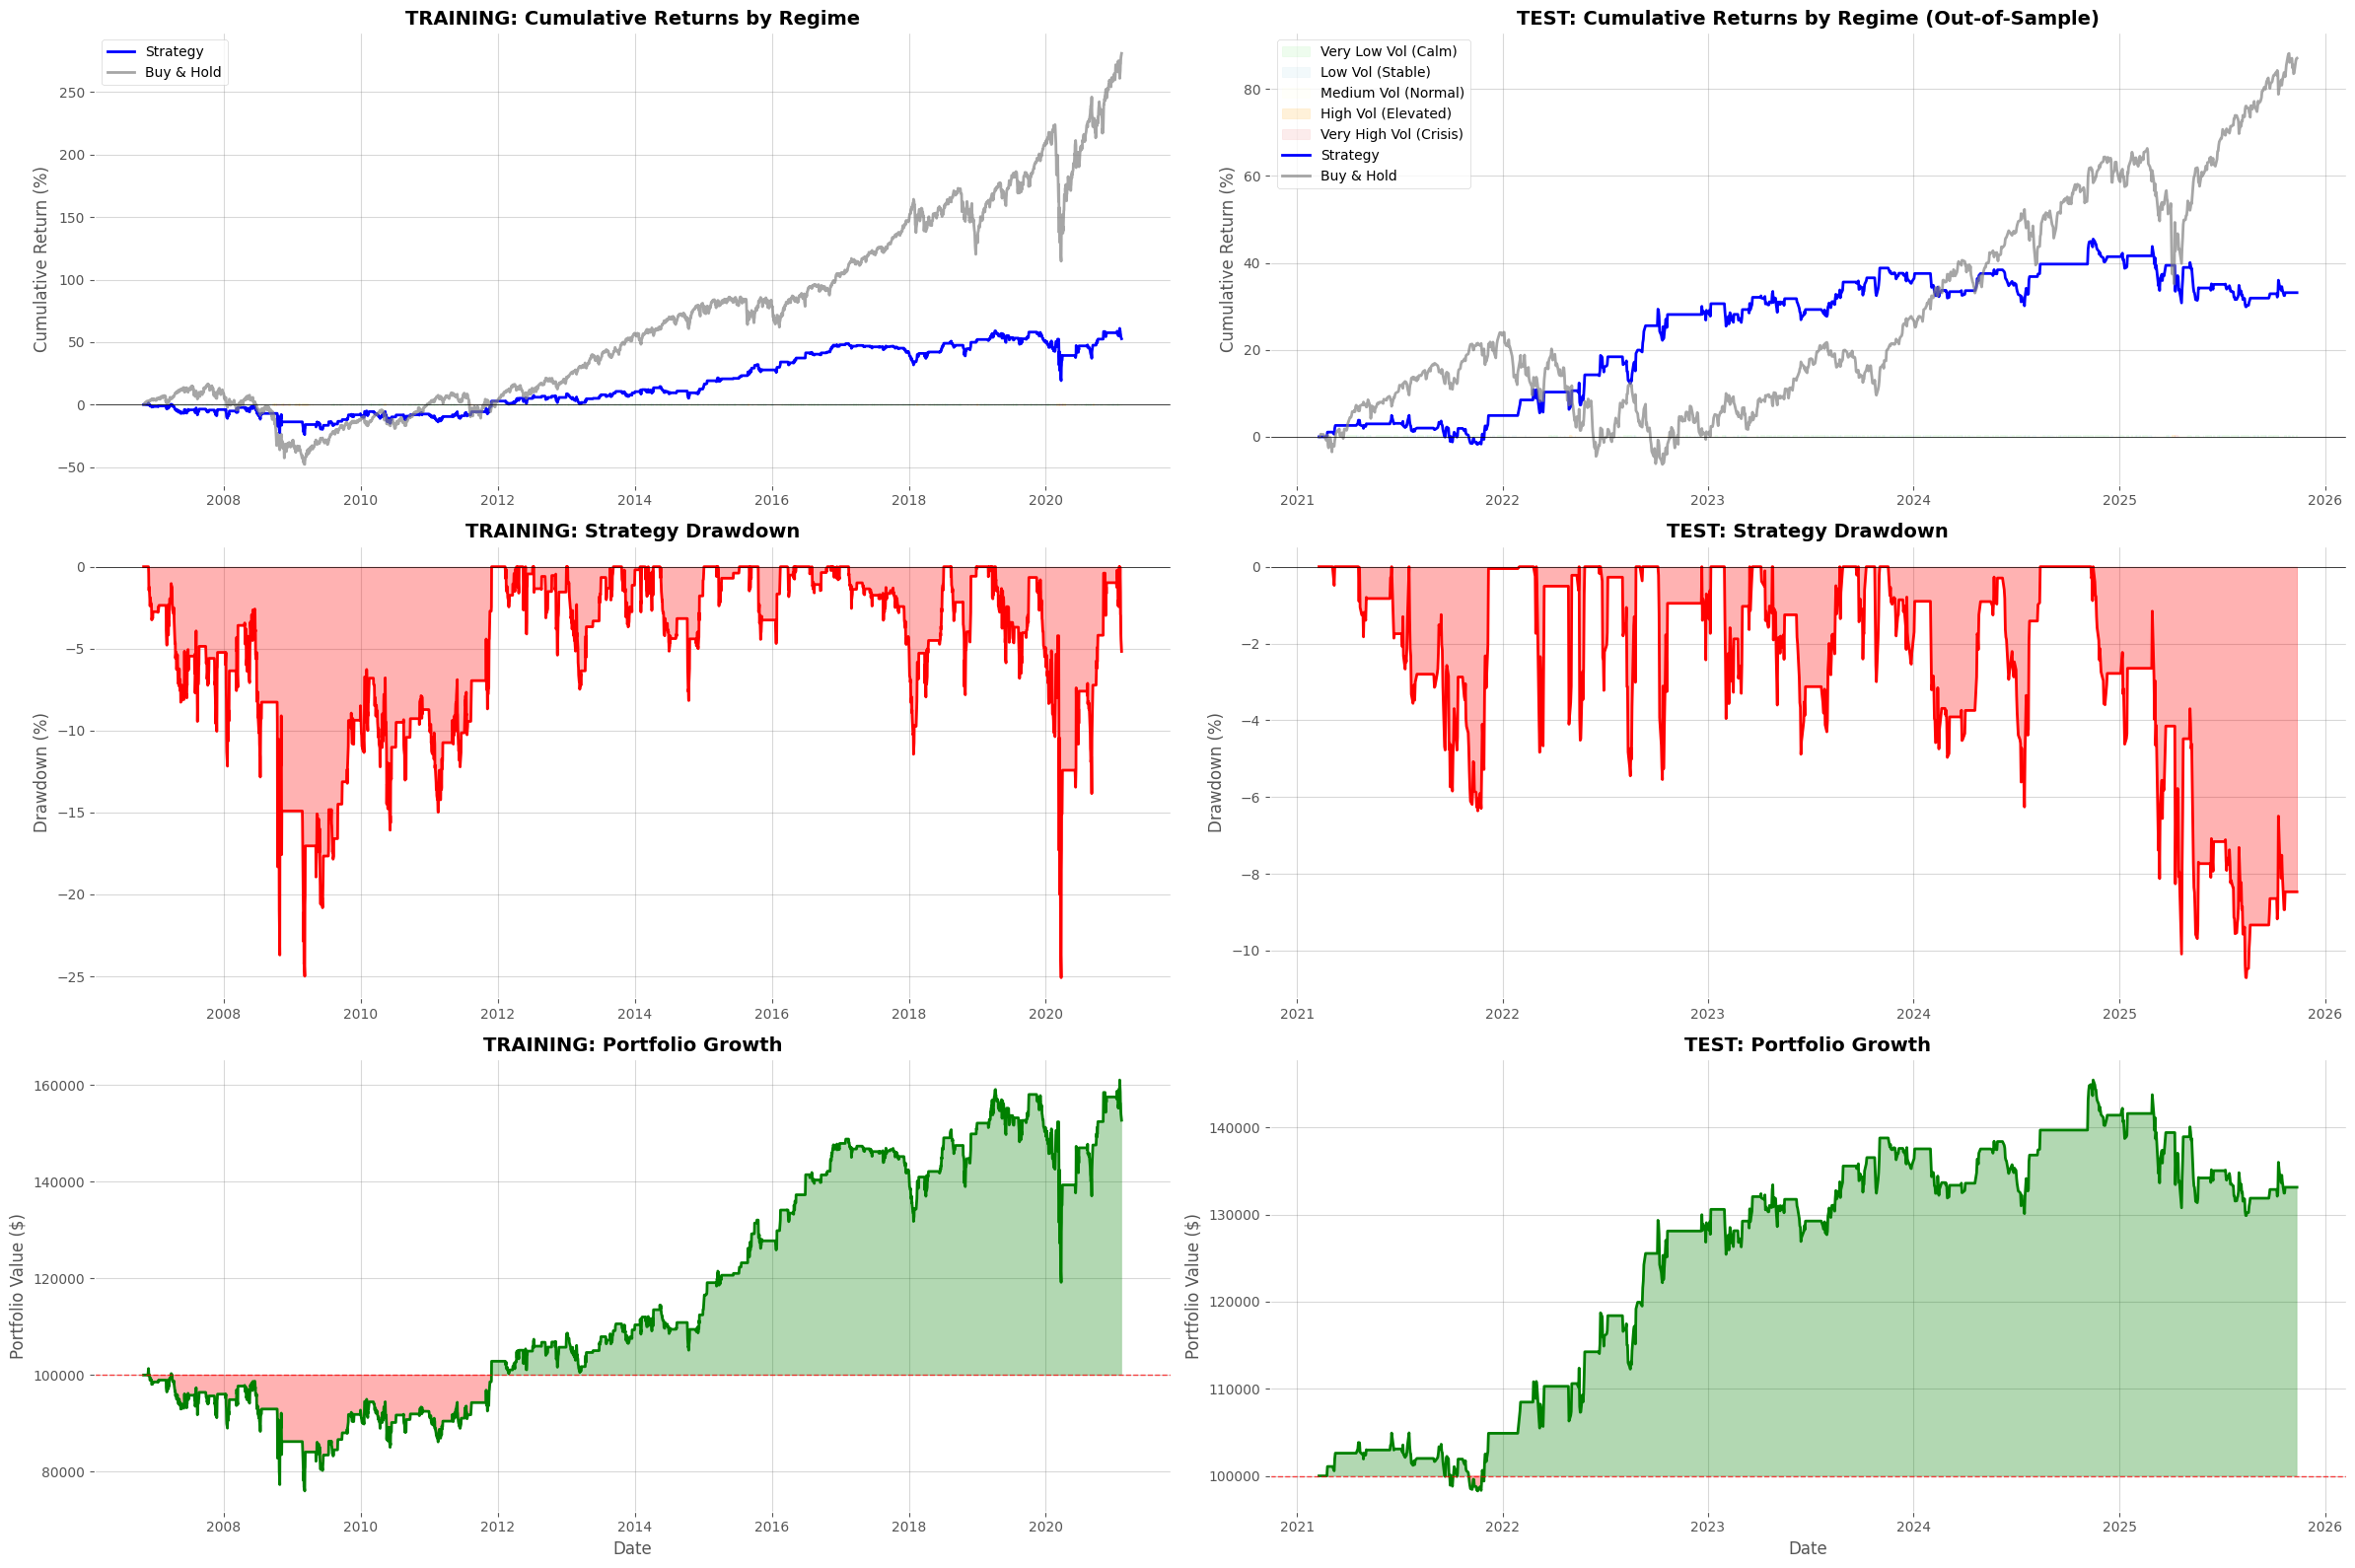


SIDE-BY-SIDE COMPARISON SUMMARY

Metric                           Strategy (Train)    Strategy (Test)    SPY B&H (Train)     SPY B&H (Test)
----------------------------------------------------------------------------------------------------
Final Return (%)                            52.71              33.14             280.95              87.04
Max Drawdown (%)                           -25.08             -10.70             -55.19             -24.50
Final Portfolio ($)            $       152,713.56 $       133,141.10 $       380,947.35 $       187,040.10


In [22]:
## Buy and Hold
from mean_reversion_codebase import *
spy, spy_train, spy_test = mr_get_spy_raw()
spy_train_features, spy_test_features = mr_atr_volatility_kmeans_clustering(spy)
spy_train_features, spy_test_features, rig_fig = mr_visualize_rsi_analysis(spy_train_features, spy_test_features)
mean_reversion_B_test_unified_results = backtest_mean_reversion_rsi_strategy(spy_train_features, spy_test_features)


## Baseline MACD

In [ ]:
baseline_macd = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=False)
baseline_macd = compute_portfolio(
    df = baseline_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,12_ewma,26_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6785.927672,6744.943283,40.984388,...,NaN,0.0,116013.384033,0.0,-1.0,0.0,0.0,116013.384033,-0.011071,1.160134
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.138769,6743.747470,33.391299,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6785.645139,6750.316559,35.328580,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6795.024328,6757.449397,37.574931,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6803.623650,6764.373139,39.250510,...,NaN,0.0,116013.384033,0.0,0.0,0.0,0.0,116013.384033,0.000000,1.160134


In [ ]:
baseline_macd_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Base)'
    )
)
print(baseline_macd_metric)

              CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
MACD (Base)  0.032       0.105         0.174          0.35           0.52   

             Calmar Ratio  Final Portfolio Value  Cumulative Return  
MACD (Base)         0.183             116013.384               1.16  


In [ ]:
baseline_macd_short = MACD(df_test, span=[12,26,9], price_col='Close', allow_short=True)
baseline_macd_short = compute_portfolio(
    df = baseline_macd_short,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

baseline_macd_short.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,12_ewma,26_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6785.927672,6744.943283,40.984388,...,NaN,-1.0,150111.667969,-11.0,-2.0,0.0,-73923.518066,76188.149902,-0.010909,0.761881
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.138769,6743.747470,33.391299,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-74016.797852,76094.870117,-0.001225,0.760949
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6785.645139,6750.316559,35.328580,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75156.731934,74954.936035,-0.015094,0.749549
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6795.024328,6757.449397,37.574931,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75312.708496,74798.959473,-0.002083,0.747990
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6803.623650,6764.373139,39.250510,...,NaN,-1.0,150111.667969,-11.0,0.0,0.0,-75360.119141,74751.548828,-0.000634,0.747515


In [ ]:
baseline_macd_short_metric = \
(
    compute_performance_metrics(
        log_returns=baseline_macd_short['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD with Short (Base)'
    )
)
baseline_macd_short_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD with Short (Base),-0.059,0.163,0.392,-0.294,-0.472,-0.152,74751.549,0.748


In [ ]:
combined_results.append(baseline_macd_metric)
combined_results.append(baseline_macd_short_metric)

## Hyperparams MACD

In [ ]:
results = []
short_choices = np.linspace(6, 20, 10).astype(int).tolist()
long_choices = np.linspace(20, 60, 10).astype(int).tolist()
signal_choices = np.linspace(5, 20, 10).astype(int).tolist()
allow_short = True

# ---- CREATE TASK LIST ----
macd_task_list = [
    (short_ma, long_ma, signal)
    for short_ma in short_choices
    for long_ma in long_choices
    if long_ma > short_ma
    for signal in signal_choices
]

In [ ]:
df_train

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns
Date,,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN,1.000000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,-0.000344,0.999656
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,-0.002226,0.997434
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,0.011283,1.008751
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,0.002215,1.010988
...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.013803,2.797399
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.001008,2.800221
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.010795,2.830612


In [ ]:
macd_hyperparam_df =\
(
    run_macd_hyperparam_search(
        df = df_train,
        price_col='Close',
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=allow_short,
        cache_file="data/hyperparams_macd.csv"
    )
)
macd_hyperparam_df

Loaded cached results from: data/hyperparams_macd.csv


,short_ma,long_ma,signal,regime,cumulative_return,sharpe
0,9,46,6,NaN,1.751703,0.207123
1,6,55,8,NaN,1.730799,0.203538
2,7,46,8,NaN,1.704261,0.197003
3,7,55,8,NaN,1.698361,0.195944
4,6,46,10,NaN,1.697069,0.195694
...,...,...,...,...,...,...
985,20,42,11,NaN,0.276656,-0.487218
986,20,24,20,NaN,0.275982,-0.488386
987,16,46,13,NaN,0.275491,-0.488653
988,15,42,15,NaN,0.270720,-0.493638


In [ ]:
best_row =\
(
    pd.DataFrame(macd_hyperparam_df)
        .sort_values("cumulative_return", ascending=False)
).iloc[0]

best_row

short_ma              9.000000
long_ma              46.000000
signal                6.000000
regime                     NaN
cumulative_return     1.751703
sharpe                0.207123
Name: 0, dtype: float64

In [ ]:
best_span_list = [best_row['short_ma'],best_row['long_ma'],best_row['signal']]
best_span_list


[9.0, 46.0, 6.0]

In [ ]:
best_span_macd = MACD(df_test, span=best_span_list, price_col='Close', allow_short=allow_short)
best_span_macd = compute_portfolio(
    df = best_span_macd,
    price_column='Close',
    position_column='positions',
    initial_capital=starting_capital,
)

best_span_macd.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,9.0_ewma,46.0_ewma,macd,...,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6790.048214,6674.820996,115.227219,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67203.198242,73508.975586,0.010389,0.735090
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6777.798532,6677.117966,100.680566,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-67287.998047,73424.175781,-0.001154,0.734242
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6788.724861,6683.726996,104.997865,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68324.301758,72387.872070,-0.014214,0.723879
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6800.301861,6690.658182,109.643679,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68466.098633,72246.075195,-0.001961,0.722461
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6810.425474,6697.477831,112.947643,...,NaN,-1.0,140712.173828,-10.0,0.0,0.0,-68509.199219,72202.974609,-0.000597,0.722030


In [ ]:
best_span_macd_metric = \
(
    compute_performance_metrics(
        log_returns=best_span_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
best_span_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722


In [ ]:
combined_results.append(best_span_macd_metric)

## Vol Clustering with MACD

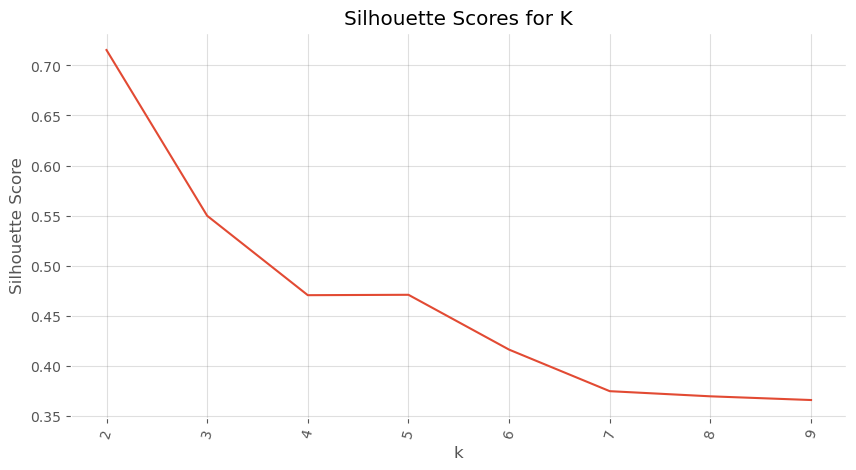

In [ ]:
scaler, kmeans, train_regimes, train_feat = compute_regime_clusters(
    df_train,
    n_clusters=None,      # auto choose using silhouette
    atr_window=14,
    vol_windows=[20, 60]
)

In [ ]:
df_train_macd =\
(
    assign_regimes(
        df_train,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)
df_train_macd

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,
2007-01-31,1438.239990,1441.609985,1424.780029,1428.650024,2976690000,0.006571,1.051491,0.0
2007-02-01,1445.939941,1446.640015,1437.900024,1437.900024,2914890000,0.005339,1.057120,0.0
2007-02-02,1448.390015,1449.329956,1444.489990,1445.939941,2569450000,0.001693,1.058912,0.0
2007-02-05,1446.989990,1449.380005,1443.849976,1448.329956,2439430000,-0.000967,1.057888,0.0
2007-02-06,1448.000000,1450.189941,1443.400024,1446.979980,2608710000,0.000698,1.058627,0.0
...,...,...,...,...,...,...,...,...
2021-02-02,3826.310059,3843.090088,3791.840088,3791.840088,5514090000,0.013803,2.797399,0.0
2021-02-03,3830.169922,3847.510010,3816.679932,3840.270020,4864870000,0.001008,2.800221,0.0
2021-02-04,3871.739990,3872.419922,3836.659912,3836.659912,4879240000,0.010795,2.830612,0.0


In [ ]:
regimes = sorted(df_train_macd["regime"].unique())

regime_dfs = { r: df_train_macd[df_train_macd["regime"] == r].copy()
               for r in regimes }

In [ ]:
regimes

[0.0, 1.0]

In [ ]:
macd_vol_clustering_hyperparam_df =\
(
    run_macd_hyperparam_search_with_regimes(
        df = df_train_macd,
        price_col='Close',
        regimes = regimes,
        macd_task_list=macd_task_list,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file="data/vol_clustering_with_macd.csv"
    )
)
macd_vol_clustering_hyperparam_df

,short_ma,long_ma,signal,regime,cumulative_return,sharpe
50,6,42,5,0.0,1.748667,0.451060
40,6,37,5,0.0,1.745270,0.448945
130,7,33,5,0.0,1.739293,0.444462
581,13,55,6,0.0,1.719698,0.429352
261,9,46,6,0.0,1.713653,0.429498
...,...,...,...,...,...,...
1776,16,55,15,1.0,0.825558,-0.168664
1865,18,51,13,1.0,0.825558,-0.168664
1489,12,60,20,1.0,0.818578,-0.175740
1659,15,46,20,1.0,0.804439,-0.193186


In [ ]:
best_per_regime = (
    macd_vol_clustering_hyperparam_df
    .sort_values("cumulative_return", ascending=False)
    .groupby("regime")
    .head(1)
    .reset_index(drop=True)
)

print(best_per_regime)


   short_ma  long_ma  signal  regime  cumulative_return    sharpe
0         6       42       5     0.0           1.748667  0.451060
1        12       42       5     1.0           1.499613  0.356207


In [ ]:
regime_macd_lookup = {
    row.regime: (row.short_ma, row.long_ma, row.signal)
    for _, row in best_per_regime.iterrows()
}

print(regime_macd_lookup)


{0.0: (6.0, 42.0, 5.0), 1.0: (12.0, 42.0, 5.0)}


In [ ]:
vol_clustering_macd_test =\
(
    assign_regimes(
        df_test,
        scaler=StandardScaler(),
        kmeans=kmeans
    )
)

vol_clustering_macd_test.head()

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime
Date,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0


In [ ]:
for r in regimes:
    df_r = vol_clustering_macd_test[vol_clustering_macd_test["regime"] == r].copy()
    spans = regime_macd_lookup[r]
    df_r = MACD(df_r, spans, price_col='Close', allow_short=False)
    vol_clustering_macd_test.loc[df_r.index, f"signal_r{r}"] = df_r["signal"]

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0
Date,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0,NaN,NaN
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0,NaN,NaN
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0,0.0,NaN
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0,NaN,NaN
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,0.0,NaN,NaN
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,0.0,NaN,NaN
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,0.0,NaN,NaN


In [ ]:
signal_cols = [col for col in vol_clustering_macd_test.columns if col.startswith("signal_r")]
signal_cols

['signal_r0.0', 'signal_r1.0']

In [ ]:
vol_clustering_macd_test["signal"] =\
(
    vol_clustering_macd_test[signal_cols]
    .bfill(axis=1)
    .iloc[:, 0]
)

In [ ]:
vol_clustering_macd_test = generate_position(vol_clustering_macd_test)

<Axes: xlabel='Date'>

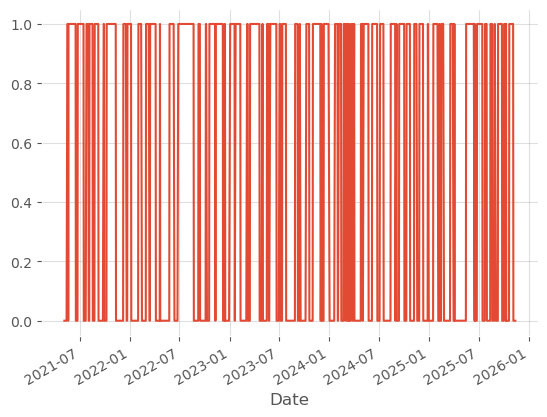

In [ ]:
vol_clustering_macd_test['positions'].plot()

In [ ]:
vol_clustering_macd_test = compute_portfolio(
    vol_clustering_macd_test,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)

vol_clustering_macd_test

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,regime,signal_r0.0,signal_r1.0,signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,
2021-05-06,4201.620117,4202.700195,4147.330078,4169.140137,4511000000,0.008132,1.074245,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-07,4232.600098,4238.040039,4201.640137,4210.339844,4016080000,0.007346,1.082166,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-10,4188.430176,4236.390137,4188.129883,4228.290039,4560700000,-0.010490,1.070873,0.0,0.0,NaN,0.0,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-11,4152.100098,4162.040039,4111.529785,4150.339844,4870710000,-0.008712,1.061584,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
2021-05-12,4063.040039,4134.729980,4056.879883,4130.549805,4733070000,-0.021683,1.038814,0.0,NaN,NaN,NaN,0.0,100000.000000,0.0,0.0,0.0,0.0,100000.000000,0.0,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,0.0,NaN,NaN,NaN,0.0,100901.150146,0.0,0.0,0.0,0.0,100901.150146,0.0,1.009012


In [ ]:
def plot_cumulative_returns(df,
                               date_column = 'Date',
                               strategy_column = 'cumulative_returns_strategy',
                               passive_column = 'cumulative_returns_passive'):
    
    melted = (
        df[[date_column, strategy_column, passive_column]]
        .melt(id_vars=date_column, var_name="Series", value_name="Value")
    )

    # Build ggplot
    plot = (
        ggplot(melted, aes(x=date_column, y="Value", color="Series"))
        + geom_line(size=1)
        + scale_color_manual(values={strategy_column: "blue", passive_column: "red"})
        + labs(
            title="Cumulative Returns Comparison",
            x="Date",
            y="Cumulative Return",
            color="Legend"
        )
        + theme(legend_position="top")
        + ggsize(1200, 500)
    )

    return plot

In [ ]:
(
    plot_cumulative_returns(
        df = vol_clustering_macd_test.reset_index(),
        date_column='Date',
        strategy_column = 'cumulative_strategy_returns',
        passive_column='cumulative_passive_returns'
    )  
)

In [ ]:
vol_clustering_macd_metric = \
(
    compute_performance_metrics(
        log_returns=vol_clustering_macd_test['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'MACD (Hyperparams)'
    )
)
vol_clustering_macd_metric

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.01,100901.15,1.009


In [ ]:
combined_results.append(vol_clustering_macd_metric)

## Momentum

In [ ]:
# Add baseline momentum here

## Momentum Hyperparams

In [ ]:
short_windows = np.arange(1,301)
long_windows  = np.arange(1,301)
momentum_tasks = [
    (s, l)
    for s in short_windows
    for l in long_windows
    if l > s
]

len(momentum_tasks)

44850

In [ ]:
momentum_hyperparam_df =\
(
    run_momentum_hyperparam_search(
        df = df_train,
        price_col='Close',
        momentum_task_list=momentum_tasks,
        starting_capital=starting_capital,
        allow_short=False,
        cache_file = "data/hyperparams_momentum.csv"
    )
)

momentum_hyperparam_df

Loaded cached Momentum results from: data/hyperparams_momentum.csv


,short_window,long_window,regime,cumulative_return,sharpe
0,277,278,NaN,3.388862,0.560872
1,20,21,NaN,3.337852,0.706133
2,148,152,NaN,3.292340,0.565609
3,195,212,NaN,3.262099,0.560792
4,194,213,NaN,3.251626,0.559792
...,...,...,...,...,...
44845,4,8,NaN,0.993139,-0.003883
44846,4,5,NaN,0.909775,-0.051587
44847,5,9,NaN,0.907663,-0.054693
44848,5,7,NaN,0.883460,-0.070324


In [ ]:
best_momentum = momentum_hyperparam_df.iloc[0]
best_short, best_long = best_momentum['short_window'], best_momentum['long_window']
best_short, best_long

(277.0, 278.0)

In [ ]:
best_momentum_df=\
(
    SMA(
        df=df_test,
        windows=[int(best_short),int(best_long)]
    )
)
best_momentum_df =\
(
    compute_portfolio(
        best_momentum_df,
        price_column='Close',
        position_column='positions',
        initial_capital=starting_capital
    )
)

In [ ]:
momentum_hyperparam_metrics =\
(
    compute_performance_metrics(
        best_momentum_df['strategy_returns'],
        initial_capital=starting_capital,
        strategy='Momentum Hyperparams'
    )
)
momentum_hyperparam_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
Momentum Hyperparams,0.08,0.15,0.233,0.586,0.908,0.342,144004.995,1.44


In [ ]:
combined_results.append(momentum_hyperparam_metrics)

### Dual MACD

In [ ]:
fast_spans = [3, 10, 16]   
slow_spans = [12, 26, 9]

dual_macd =\
(
    DUAL_MACD(
        df=df_test,
        fast_spans=fast_spans,
        slow_spans=slow_spans,
        price_column="Close",
        allow_short=False,  
    )
)

dual_macd.head(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,fast_ewma_short,fast_ewma_long,fast_macd,fast_signal,slow_ewma_short,slow_ewma_long,slow_macd,slow_signal,fast_cross_up,fast_cross_down,dual_macd_signal
Date,,,,,,,,,,,,,,,,,,
2021-02-09,3911.229980,3918.350098,3902.639893,3910.489990,4568320000,NaN,1.000000,3911.229980,3911.229980,0.000000,0.000000,3911.229980,3911.229980,0.000000,0.000000,False,False,NaN
2021-02-10,3909.879883,3931.500000,3884.939941,3920.780029,4837070000,-0.000345,0.999655,3910.329915,3910.487427,-0.157511,-0.083678,3910.498678,3910.528968,-0.030291,-0.016828,False,True,0.0
2021-02-11,3916.379883,3925.989990,3890.389893,3916.399902,4590960000,0.001661,1.001317,3913.787040,3912.856155,0.930885,0.297608,3912.794113,3912.631145,0.162968,0.056859,True,False,1.0
2021-02-12,3934.830078,3937.229980,3905.780029,3911.649902,4135060000,0.004700,1.006034,3925.009993,3920.095584,4.914410,1.676642,3919.750006,3918.836997,0.913010,0.346883,False,False,NaN
2021-02-16,3932.590088,3950.429932,3923.850098,3939.610107,5058990000,-0.000569,1.005461,3928.922300,3923.682416,5.239884,2.577819,3923.238611,3922.026395,1.212215,0.604300,False,False,NaN


In [ ]:
dual_macd = generate_position(
    dual_macd,
    signal_column='dual_macd_signal'
)
dual_macd = compute_portfolio(
    dual_macd,
    price_column='Close',
    position_column="positions",
    initial_capital=starting_capital
)
dual_macd.tail(5)

Price,Close,High,Low,Open,Volume,passive_returns,cumulative_passive_returns,fast_ewma_short,fast_ewma_long,fast_macd,...,dual_macd_signal,positions,our_cash,shares,trade_flag,transaction_cost,our_holdings,total,strategy_returns,cumulative_strategy_returns
Date,,,,,,,,,,,,,,,,,,,,,
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.011241,1.718211,6761.655676,6789.225371,-27.569695,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,0.001261,1.720379,6745.227740,6778.238905,-33.011164,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,0.015284,1.746875,6788.828958,6788.091863,0.737095,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-11,6846.609863,6855.129883,6806.870117,6815.640137,4983490000,0.002073,1.750500,6817.719411,6798.731499,18.987911,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677
2025-11-12,6850.919922,6869.910156,6829.620117,6867.770020,5293610000,0.000629,1.751602,6834.319666,6808.220304,26.099363,...,NaN,0.0,128967.672607,0.0,0.0,0.0,0.0,128967.672607,0.0,1.289677


In [ ]:
dual_macd_metrics = \
(
    compute_performance_metrics(
        log_returns=dual_macd['strategy_returns'].fillna(0),
        initial_capital=starting_capital,
        strategy = 'Dual MACD'
    )
)
print(dual_macd_metrics)


            CAGR  Volatility  Max Drawdown  Sharpe Ratio  Sortino Ratio  \
Dual MACD  0.055       0.098         0.118         0.594          0.909   

           Calmar Ratio  Final Portfolio Value  Cumulative Return  
Dual MACD         0.467             128967.673               1.29  


In [ ]:
(
    plot_cumulative_returns(
        df =dual_macd.reset_index(),
        passive_column='cumulative_passive_returns',
        strategy_column='cumulative_strategy_returns'
    )
)

In [ ]:
combined_results.append(dual_macd_metrics)

### Supervised Learning - Predict Daily Returns

In [ ]:
return_period = 1
Y =\
(
    np
    .log(spy['Close']
        )
    .diff(return_period)
    .shift(-return_period)
)

Y.name = 'SPY_pred'

Y

Date
2006-11-01   -0.000344
2006-11-02   -0.002226
2006-11-03    0.011283
2006-11-06    0.002215
2006-11-07    0.002081
                ...   
2025-11-06    0.001261
2025-11-07    0.015284
2025-11-10    0.002073
2025-11-11    0.000629
2025-11-12         NaN
Name: SPY_pred, Length: 4788, dtype: float64

In [ ]:
lag_periods = [i for i in range(1,11)]
vol_periods = [5,10,20,60,120]
sma_periods = [63]
ema_periods = [10,30]
rsi_periods = [10,30]
stok_periods = [30]
stod_periods = [30]
roc_periods = [30]
atr_periods = [5, 14, 21]


X = create_all_features(
    spy,
    price_column='Close',
    lagged_return_periods=lag_periods,
    vol_periods=vol_periods,
    sma_periods=sma_periods,
    ema_periods=ema_periods,
    rsi_periods=rsi_periods,
    stok_periods=stok_periods,
    stod_periods=stod_periods,
    roc_periods=roc_periods,
    atr_periods=atr_periods
)

X

,1DT,2DT,3DT,4DT,5DT,6DT,7DT,8DT,9DT,10DT,...,EMA10,EMA30,RSI10,RSI30,%K30,%D30,ROC30,ATR5,ATR14,ATR21
Date,,,,,,,,,,,,,,,,,,,,,
2006-11-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.810059,1367.810059,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-02,-0.000344,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.724587,1367.779730,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-03,-0.002226,-0.002569,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1367.101944,1367.555234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-06,0.011283,0.009057,0.008713,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1369.407050,1368.343931,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2006-11-07,0.002215,0.013498,0.011272,0.010928,NaN,NaN,NaN,NaN,NaN,NaN,...,1371.849399,1369.279159,NaN,NaN,NaN,NaN,NaN,11.740015,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-06,-0.011241,-0.007594,-0.019400,-0.017681,-0.015067,-0.025021,-0.025065,-0.022779,-0.010564,-0.002693,...,6789.225371,6731.548794,47.876348,54.873023,45.876180,57.349299,1.153267,73.542090,67.680734,83.421015
2025-11-07,0.001261,-0.009980,-0.006333,-0.018139,-0.016420,-0.013806,-0.023760,-0.023803,-0.021518,-0.009303,...,6778.238905,6731.371440,41.808905,53.669848,48.170795,53.493363,1.014678,80.294043,68.989990,85.814337
2025-11-10,0.015284,0.016545,0.005304,0.008950,-0.002856,-0.001137,0.001478,-0.008476,-0.008520,-0.006235,...,6788.091863,6737.891358,44.792050,56.820149,76.212346,56.753107,2.152517,90.458105,74.874965,81.095285


In [ ]:
data =\
(
    pd
    .concat([Y, X],
            axis = 1)
    .dropna()
)

Y =\
(
    data
    .loc[ : , Y.name]
)
X =\
(
    data
    .loc[ : , X.columns]
)

In [ ]:
SL =\
(
    SupervisedLearning()
)

In [ ]:
X_train, X_test, Y_train, Y_test =\
(
    SL
    .sequential_split(X,Y,train_frac=0.75)
    
)

Sequential Split: 3501 train / 1167 test samples


In [ ]:
seed = 2025
num_folds = 10

metric = "neg_mean_squared_error"

In [ ]:
results =\
(
    SL
    .run_all_models(
        X_train = X_train,
        Y_train = Y_train,
        X_test = X_test,
        Y_test = Y_test,
        num_folds = num_folds,
        seed = seed,
        metric = metric
    )
)

LR: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
LASSO: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Elastic Net Penalty: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0002, Test_MSE=0.0001
Decision Tree: CV_Mean=0.0003, CV_Std=0.0001, Train_MSE=0.0000, Test_MSE=0.0004
Random Forest: CV_Mean=0.0002, CV_Std=0.0001, Train_MSE=0.0000, Test_MSE=0.0002
Extra Trees: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0000, Test_MSE=0.0002
Gradient Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0002
Adaptive Boosting: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001
Support Vector Machine: CV_Mean=0.0002, CV_Std=0.0001, Train_MSE=0.0002, Test_MSE=0.0002
K-Nearest Neighbors: CV_Mean=0.0002, CV_Std=0.0000, Train_MSE=0.0001, Test_MSE=0.0001


In [ ]:
(
    SL
    .plot_performance(results['comparison_df'])
)

In [ ]:
# chosen model is K-Nearest Neighbors
model =\
(
    SL.get_model_by_name("K-Nearest Neighbors")
)

model

,n_neighbors,5
,weights,'uniform'
,algorithm,'auto'
,leaf_size,30
,p,2
,metric,'minkowski'
,metric_params,None
,n_jobs,None


In [ ]:
model.fit(X_train, Y_train)

y_pred = model.predict(X_test)

In [ ]:
testing_df =\
(
    spy
    .copy()
    .rename(columns={'Close': "actual_close"})
)

testing_df

Price,actual_close,High,Low,Open,Volume
Date,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000
...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000


In [ ]:
testing_df.loc[X_test.index, "pred_return"] = y_pred
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return
Date,,,,,,
2006-11-01,1367.810059,1381.949951,1366.260010,1377.760010,2821160000,NaN
2006-11-02,1367.339966,1368.390015,1362.209961,1367.439941,2646180000,NaN
2006-11-03,1364.300049,1371.680054,1360.979980,1367.310059,2419730000,NaN
2006-11-06,1379.780029,1381.400024,1364.270020,1364.270020,2533550000,NaN
2006-11-07,1382.839966,1388.189941,1379.189941,1379.750000,2636390000,NaN
...,...,...,...,...,...,...
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652
2025-11-10,6832.430176,6841.319824,6770.560059,6785.359863,5366050000,-0.002652


In [ ]:
testing_df["pred_close"] =\
(
    testing_df["actual_close"] 
    * np.exp(testing_df["pred_return"])
)

In [ ]:
def generate_signal_simple(df: pd.DataFrame):
    df = df.copy()
    df['signal'] = (df['pred_return'] > 0).astype(int)

    df['positions'] = df['signal'] 
    # no need to shift(1) cause we using predicted returns
    return df

In [ ]:
def compute_cumulative_returns(df, 
                       position_column = 'positions',
                       price_column = 'Close'):
    df = df.copy()

    df["passive_returns"] =\
    (
        np
        .log(df[price_column]
            /
            df[price_column].shift(1)
            )
    )

    df['strategy_returns'] =\
    (
        df[position_column].shift(1)
        *
        df['passive_returns']
    )

    df['cum_log_returns'] =\
    (
        df['strategy_returns']
        .cumsum()
    )

    df['cumulative_returns_strategy'] =\
    (
        np.exp(
            df['cum_log_returns']
        )
    )

    df['cumulative_max_strategy'] =\
    (
        df['cumulative_returns_strategy']
        .cummax()
    )

    df['cumulative_returns_passive'] =\
    (
        np.exp(
            df['passive_returns']
            .cumsum()
        )
    )
    return df

In [ ]:
testing_df =\
(
    generate_signal_simple(testing_df)
    .dropna()
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions
Date,,,,,,,,,
2021-03-23,3910.520020,3949.129883,3901.570068,3937.600098,4669010000,-0.002652,3900.164805,0,0
2021-03-24,3889.139893,3942.080078,3889.070068,3919.929932,4783020000,-0.002652,3878.841294,0,0
2021-03-25,3909.520020,3919.540039,3853.500000,3879.340088,4948340000,-0.002652,3899.167453,0,0
2021-03-26,3974.540039,3978.189941,3917.120117,3917.120117,5483160000,-0.002652,3964.015297,0,0
2021-03-29,3971.090088,3981.830078,3943.250000,3969.310059,4628180000,-0.002652,3960.574482,0,0
...,...,...,...,...,...,...,...,...,...
2025-11-05,6796.290039,6829.779785,6763.109863,6769.770020,5939600000,-0.002652,6778.293190,0,0
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652,6702.524147,0,0
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652,6710.981672,0,0


In [ ]:
testing_df =\
(
    compute_cumulative_returns(
        df = testing_df,
        position_column='positions',
        price_column = 'actual_close'
    )
)
testing_df

Price,actual_close,High,Low,Open,Volume,pred_return,pred_close,signal,positions,passive_returns,strategy_returns,cum_log_returns,cumulative_returns_strategy,cumulative_max_strategy,cumulative_returns_passive
Date,,,,,,,,,,,,,,,
2021-03-23,3910.520020,3949.129883,3901.570068,3937.600098,4669010000,-0.002652,3900.164805,0,0,NaN,NaN,NaN,NaN,NaN,NaN
2021-03-24,3889.139893,3942.080078,3889.070068,3919.929932,4783020000,-0.002652,3878.841294,0,0,-0.005482,-0.0,0.000000,1.000000,1.000000,0.994533
2021-03-25,3909.520020,3919.540039,3853.500000,3879.340088,4948340000,-0.002652,3899.167453,0,0,0.005227,0.0,0.000000,1.000000,1.000000,0.999744
2021-03-26,3974.540039,3978.189941,3917.120117,3917.120117,5483160000,-0.002652,3964.015297,0,0,0.016494,0.0,0.000000,1.000000,1.000000,1.016371
2021-03-29,3971.090088,3981.830078,3943.250000,3969.310059,4628180000,-0.002652,3960.574482,0,0,-0.000868,-0.0,0.000000,1.000000,1.000000,1.015489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-11-05,6796.290039,6829.779785,6763.109863,6769.770020,5939600000,-0.002652,6778.293190,0,0,0.003647,0.0,0.157973,1.171134,1.171134,1.737950
2025-11-06,6720.319824,6796.680176,6707.509766,6787.589844,6051900000,-0.002652,6702.524147,0,0,-0.011241,-0.0,0.157973,1.171134,1.171134,1.718523
2025-11-07,6728.799805,6730.109863,6631.439941,6696.180176,5926070000,-0.002652,6710.981672,0,0,0.001261,0.0,0.157973,1.171134,1.171134,1.720692


In [ ]:
ml_pred_returns_metrics =\
(
    compute_performance_metrics(
        log_returns=testing_df['strategy_returns'],
        initial_capital=100_000,
        strategy='ML (Predict Returns)'
    )
)

ml_pred_returns_metrics

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
ML (Predict Returns),0.035,0.058,0.056,0.613,1.151,0.614,117113.447,1.171


In [ ]:
combined_results.append(ml_pred_returns_metrics)

## 👇 <a id = "part2"></a><font color = blue> 👉 Part 2 - Results of Strategies </font> [back to table of contents](#top)

In [ ]:
(
    pd.concat(
        combined_results,
        axis=0
    )
    .sort_values(by='Final Portfolio Value', ascending=False)
)

,CAGR,Volatility,Max Drawdown,Sharpe Ratio,Sortino Ratio,Calmar Ratio,Final Portfolio Value,Cumulative Return
Buy and Hold,0.125,0.171,0.254,0.776,1.273,0.492,175160.243,1.752
Momentum Hyperparams,0.080,0.150,0.233,0.586,0.908,0.342,144004.995,1.440
Dual MACD,0.055,0.098,0.118,0.594,0.909,0.467,128967.673,1.290
ML (Predict Returns),0.035,0.058,0.056,0.613,1.151,0.614,117113.447,1.171
MACD (Base),0.032,0.105,0.174,0.350,0.520,0.183,116013.384,1.160
MACD (Hyperparams),0.002,0.107,0.192,0.072,0.105,0.010,100901.150,1.009
MACD with Short (Base),-0.059,0.163,0.392,-0.294,-0.472,-0.152,74751.549,0.748
MACD (Hyperparams),-0.066,0.163,0.373,-0.338,-0.539,-0.177,72202.975,0.722


## 👇 <a id = "part3"></a><font color = blue> Part 3 - Executive Summary</font> [back to table of contents](#top)

### Machine-Learning Review

We predicted daily and weekly (5-day log returns) using supervised learning models, incorporating features from S&P 500 price and volume data.

While our machine learning strategies seemed promising when tested on the training data, they ran into real problems when faced with new, unseen data. The best results, at least by RMSE, came from linear models like Linear Regression, LASSO, and Elastic Net, as well as K-Nearest Neighbors. But in practice, these models didn’t give us useful or realistic trading signals. 

The linear models tended to make almost the same prediction over and over—usually a small, positive value—so the strategy basically just bought and held the index. In fact, our actual trading rule was simple: buy when the model predicted returns above zero, and otherwise just hold. But since the predictions rarely dropped below zero, we ended up almost always in a buy position, which didn’t really add any practical value over a basic buy-and-hold approach. 

That’s a sign the models couldn’t find meaningful patterns in the data, probably because predicting daily S&P 500 returns is extremely tough, with very little signal compared to the noise. K-Nearest Neighbors, meanwhile, made predictions that hovered around zero, with the occasional odd spike—likely just picking up on random noise rather than anything real. 

These problems point to bigger challenges: risks of using future information by accident (lookahead bias), models that break down when the market changes, and the fact that stock index returns are notoriously hard to predict and often behave almost randomly. 

There are also issues like possible survivorship bias in our data, overfitting to features, and assuming that past relationships will hold in the future—even when economic conditions shift, which is highly likely for our case, as we had a long prediction period of almost 5 years, and also we were unable to use macroeconomic features that could have possibly helped with the better prediction

### Momentum Strategy Review

This momentum-based trading strategy is implemented on the S&P 500 index (^GSPC) using moving average crossovers from November 2006 to November 2025. The core strategy employs a 20-day short moving average and an 80-day long moving average to generate buy and sell signals.

Strategy Logic: The system generates a buy signal when the 20-day MA crosses above the 80-day MA, indicating upward momentum, and a sell signal when it crosses below, suggesting downward momentum. This crossover approach aims to capture trending market movements while avoiding sideways market noise.

Position Sizing Analysis: The project compares two distinct approaches:

Fixed Position Sizing: Uses a constant 8 shares per trade[8 is an arbitrary number], resulting in a final portfolio value of $126,732 or 26.73% return 
Risk-Based Position Sizing: Allocates 10% of current portfolio value per trade, achieving $111,852 (11.85% return)

Performance Metrics: Both approaches show identical Sharpe ratios (0.49), but the risk-based method demonstrates superior risk management with significantly lower volatility (1.23% vs 2.64%) and maximum drawdown (-3.31% vs -9.29%). The fixed approach generates higher absolute returns but with substantially increased risk.

Issues we faced/approaches that could be sharpen:
- Which Moving average pair should we incorporate: Since we are testing on the last 25% of the timeframe, we wanted trades to be executed more often. Whereas, if the MA's were far greater (say 100,200 MA), would equate to fewer trade opportunities.
- Transaction costs not considered: Our analysis assumes zero transaction costs, but in reality, each buy/sell would incur brokerage fees and bid-ask spreads, which could significantly impact the strategy's profitability, especially with frequent trading.
- Lagging nature of moving averages: The crossover signals inherently lag behind actual trend changes, meaning we often enter positions after significant price movements have already occurred, potentially missing optimal entry/exit points.
- Risk management limitations: The strategy lacks stop-loss mechanisms or position sizing based on volatility, making it vulnerable to prolonged drawdowns during volatile market periods or false breakouts.
- Market regime sensitivity: The 20/80 MA combination may perform differently across various market conditions (bull, bear, sideways), suggesting the need for adaptive parameters or regime-detection mechanisms.
- Optimization and overfitting risk: While we tested 20/80 MA, more systematic parameter optimization across different MA combinations could improve performance, though this risks overfitting to historical data. 


### Mean Reversion

This project implements a sophisticated mean reversion trading strategy on the S&P 500 (SPY) from November 2006 to November 2025, using Z-score-based signals derived from rolling moving averages and standard deviations. The strategy operates on the principle that asset prices tend to revert to their historical mean, entering long positions when prices deviate significantly below the mean and short positions when prices spike above normal levels.

Strategy Implementation: The core algorithm calculates Z-scores using a rolling window approach, where Z = (Current Price - Rolling Mean) / Rolling Standard Deviation. The optimized parameters, determined through comprehensive hyperparameter testing on the training set (75% of data), include a 9-day rolling window, long entry threshold of -1.1 Z-score, short entry threshold of +1.75 Z-score, and capital-based position sizing using 98% of available capital per trade.

Training vs. Test Performance: The strategy demonstrates significant performance variation between training and out-of-sample periods. During training (2006-2021), the strategy achieved exceptional results with 268.52% total return, 9.57% CAGR, and 0.670 Sharpe ratio, despite experiencing a maximum drawdown of -32.66%. However, the out-of-sample test period (2021-2025) revealed more modest performance with 23.57% total return, 4.55% CAGR, 0.412 Sharpe ratio, and improved -18.89% maximum drawdown.

Full Period Analysis: When applied to the complete dataset (2006-2025), the strategy delivered robust performance with 355.50% total return, 8.29% CAGR, and 0.613 Sharpe ratio. The strategy's ability to maintain positive performance across different market regimes, including the 2008 financial crisis and COVID-19 pandemic, demonstrates its resilience, though the significant performance degradation in recent years suggests potential challenges with evolving market dynamics and the need for parameter re-optimization.


## 👇 <a id = "part4"></a><font color = blue> Part 4 - Self-Critique</font> [back to table of contents](#top)

### Momentum Strategy

Although the strategy generated positive returns, several limitations reduced its overall robustness. The moving-average crossover framework is inherently lagging, often triggering entries only after a trend has already taken shape and exits only after a significant portion of a reversal has unfolded. This delay weakens the strategy’s ability to capture turning points and increases susceptibility to whipsaws during sideways or choppy market conditions.
The selection of the 20/80 MA combination was also not derived from systematic parameter exploration. Prioritizing higher trade frequency over a broader, data-driven search likely introduced bias. Furthermore, the backtest assumed zero transaction costs, which is unrealistic and would meaningfully erode performance for a strategy that trades relatively often. Both position-sizing approaches—fixed shares and a simple risk-based method—lacked volatility sensitivity and failed to adjust exposure during periods of heightened market stress.
Additionally, the strategy omitted key risk-management tools such as stop-losses, trailing exits, and regime-adaptation mechanisms, leaving it vulnerable to sharp drawdowns and structural market shifts. Finally, because performance is highly regime-dependent and no walk-forward validation was conducted, the risk of overfitting remains material.

## 👇 <a id = "part4"></a><font color = blue> Part 5 - Contribution Statement</font> [back to table of contents](#top)

Contribution Statement


#### Mikhail 
I contributed to both the technical implementation and comprehensive documentation of our quantitative finance project. My primary technical contribution was the momentum trading strategy using moving average crossovers on the S&P 500 index. I developed and analyzed a 20-day/80-day moving average crossover system, implementing two distinct position sizing approaches: fixed 8-share allocation and dynamic risk-based sizing using 10% of portfolio value per trade.

The momentum strategy analysis included comprehensive performance metrics calculation (Sharpe ratio, CAGR, maximum drawdown) and specialized examination of the last 25% timeframe with normalized $100K starting values. I demonstrated that while the fixed approach achieved higher absolute returns (26.73%), the risk-based method provided superior risk management with significantly lower volatility and drawdown.

Beyond technical implementation, I authored the Executive Summary (Part 3) of our combined notebook, providing detailed analysis of all three strategies: machine learning, momentum, and mean reversion. This comprehensive documentation includes strategy methodology explanations, performance comparisons, limitations analysis, and actionable insights for each approach, synthesizing our team's collective findings into a cohesive strategic overview for stakeholders.